In [1]:
""" 
21 MARCH 2024 
Theo Gauvrit
Testing if the responsivity pattern are different between WT and KO groups
"""

import percephone.core.recording as pc
import percephone.plts.behavior as pbh
import percephone.plts.stats as ppt
import percephone.analysis.mlr_models as mlr_m
import numpy as np
import pandas as pd
import scipy.stats as ss
from multiprocessing import Pool, cpu_count, pool
import os
import matplotlib
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.formula.api import ols
import matplotlib as mpl


plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
save_figure = False

In [2]:
user = "Célien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
    server_address = "Z:/Current_members/Ourania_Semelidou/2p/Figures_paper/"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    server_address = "/run/user/1004/gvfs/smb-share:server=engram.local,share=data/Current_members/Ourania_Semelidou/2p/Figures_paper/"
elif user == "Adrien":
    directory = "C:/Users/acorniere/Desktop/percephone_data/"
    roi_path = directory + "FmKO_ROIs&inhibitory.xlsx"

roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
   pool = Pool(processes=workers)
elif user == "Adrien":
    pool = pool.ThreadPool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

In [3]:
def fraction_resp(pattern, n_type, ko_hypo_only=True, stim_ampl="all", no_go_normalize=True):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        no_go_filter = rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_no_go = resp_mat[:, no_go_filter]
        trials_detected = resp_mat[:, ampl_det_filt]
        trials_undetected = resp_mat[:, ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
            trials_no_go[trials_no_go!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0
            trials_no_go[trials_no_go!=pattern]=0
        
        # The total number of neurons is computed
        total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
        
        # Computation of the number of responsive neurons
        recruited_det = np.mean(np.count_nonzero(trials_detected, axis=0))
        recruited_undet = np.mean(np.count_nonzero(trials_undetected, axis=0))
        
        # Normalization by the number of responsive neurons for no-go trials
        if no_go_normalize:
            recruited_no_go = np.mean(np.count_nonzero(trials_no_go, axis=0))
            recruited_det -= recruited_no_go
            recruited_undet -= recruited_no_go
            recruited_det = 0 if recruited_det < 0 else recruited_det
            recruited_undet = 0 if recruited_undet < 0 else recruited_undet
        
        # Computation of the percentage of responsive neurons
        perc_n_det = (recruited_det/total_n)*100
        perc_n_undet = (recruited_undet/total_n)*100
        
        # Storing the computed percentage in the corresponding list
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
        elif rec.genotype == "KO" and not ko_hypo_only:
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    return np.array(wt_det), np.array(ko_det), np.array(wt_undet), np.array(ko_undet)

In [4]:
def plot_neuron_frac_wt_ko(pattern, ko_hypo_only=True, stim_ampl="all", ylim=[], no_go_normalize=True):
    if ko_hypo_only:
        ko_type = "KO-Hypo"
        color_ko = ppt.hypo_color
        light_color_ko = ppt.hypo_light_color
    else:
        ko_type = "(KO + KO-Hypo)"
        color_ko = ppt.all_ko_color
        light_color_ko = ppt.all_ko_light_color
        
    fig, axs = plt.subplots(2, 2, figsize=(12,16))
    for y_index, n_type in enumerate(["EXC", "INH"]):
        wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pattern, n_type=n_type, ko_hypo_only=ko_hypo_only, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
        ppt.boxplot(axs[y_index, 0], wt_det, ko_det, paired=False, ylabel="Neurons(%)", title=f"{n_type} Detected", ylim=ylim, 
                    colors=[ppt.wt_color, color_ko], det_marker=True)
        ppt.boxplot(axs[y_index, 1], wt_undet, ko_undet, paired=False, ylabel="Neurons(%)", title=f"{n_type} Undetected", ylim=ylim, 
                    colors=[ppt.wt_light_color, light_color_ko], det_marker=False)

    t_pattern = "recruited (1 and -1)" if pattern == 0 else ("activated (1)" if pattern == 1 else "inhibited (-1)")
    fig.suptitle(f"Percentage of neurons {t_pattern} during hit and miss trials (amplitude: {stim_ampl}) - WT vs. {ko_type}", fontsize=5)
    fig.tight_layout()
    if save_figure:
        title = f"Figure2/responsivity/fr_n_{t_pattern}_{stim_ampl}.pdf"
        fig.savefig(server_address + title)

# Comparison WT vs Ko-Hypo

## Fraction of neurons recruited ( 1 and -1) 


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7605448747105653, pvalue=0.0071824560119444466)
ShapiroResult(statistic=0.7022358858427965, pvalue=0.003921438331208252)
MannwhitneyuResult(statistic=55.0, pvalue=0.011538461538461539)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.90840723698374, pvalue=0.3048854173056489)
ShapiroResult(statistic=0.7543822991515912, pvalue=0.014095265548138208)
MannwhitneyuResult(statistic=46.0, pvalue=0.12811107444286923)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6388705419286028, pvalue=0.00027335156502576356)
ShapiroResult(statistic=0.8391799296593461, pvalue=0.09762341836686572)
MannwhitneyuResult(statistic=50.0, pvalue=0.0548951048951049)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7694249516981773, pvalue=0.009096936997145913)
ShapiroResult(statistic=0.6767304652893897, pvalue=0.0020544209867010693)
MannwhitneyuResult(statistic=53.0, pvalue=0.02405158033253627)
Boxplot plotting.

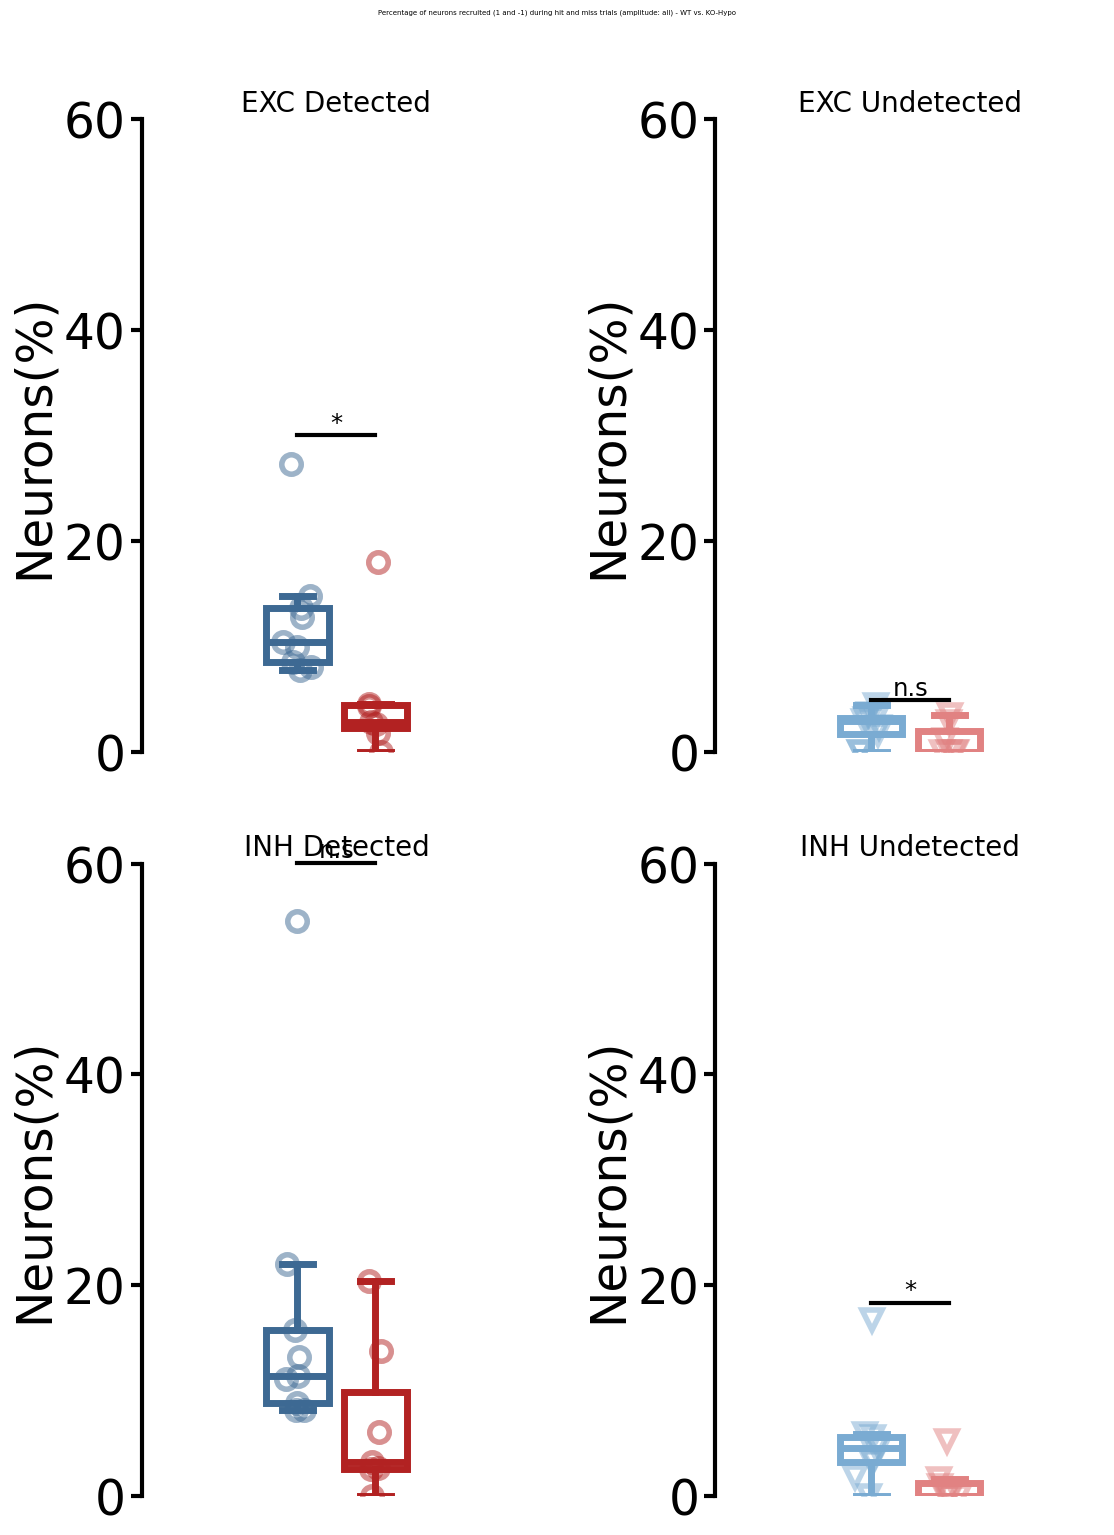

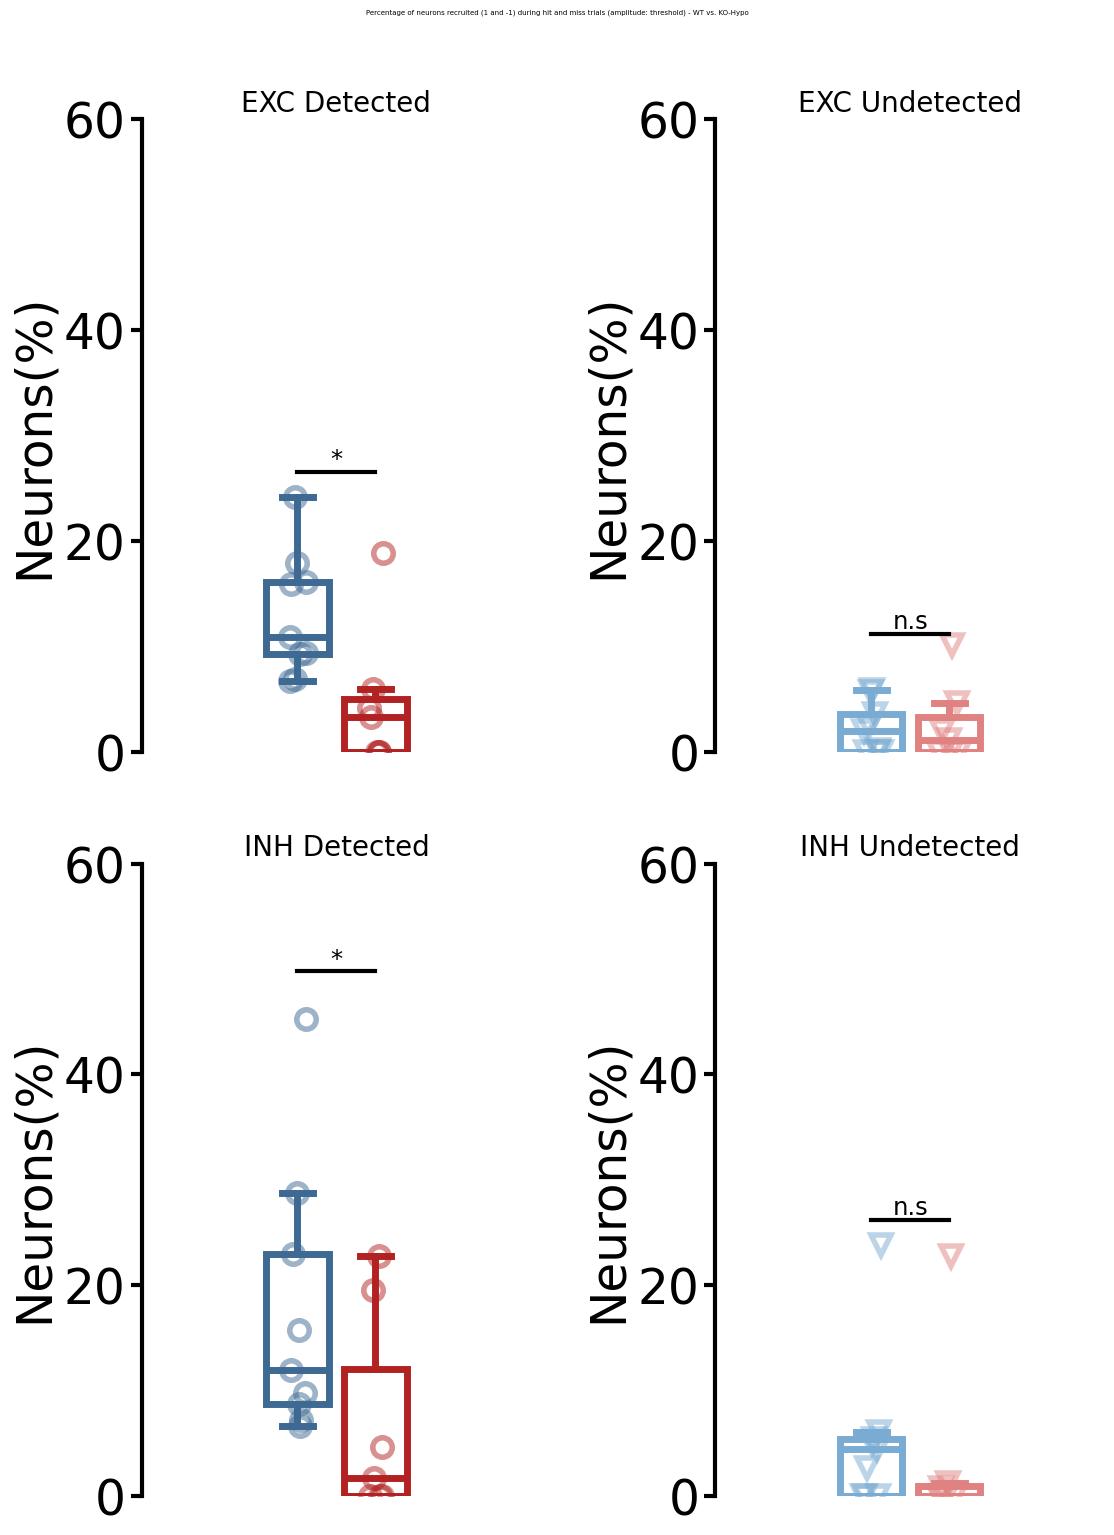

In [5]:
plot_neuron_frac_wt_ko(pattern=0, ko_hypo_only=True, stim_ampl="all", no_go_normalize=True, ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=0, ko_hypo_only=True, stim_ampl="threshold", no_go_normalize=True, ylim=[0, 60])

## Fraction of neurons activated (1) 

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9084076207649606, pvalue=0.3048880270822422)
ShapiroResult(statistic=0.7215215282682894, pvalue=0.006337320135485719)
MannwhitneyuResult(statistic=53.0, pvalue=0.022902097902097907)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9652264296775498, pvalue=0.851107846363746)
ShapiroResult(statistic=0.7709612112028134, pvalue=0.02089899651998921)
MannwhitneyuResult(statistic=42.5, pvalue=0.26284100577277614)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9448140749476439, pvalue=0.6333839709214009)
ShapiroResult(statistic=0.9508905857322528, pvalue=0.7377997389548656)
LeveneResult(statistic=1.6303151876726292, pvalue=0.22243175802811918)
Equal variances :TtestResult(statistic=1.9023773582111485, pvalue=0.077895450184839

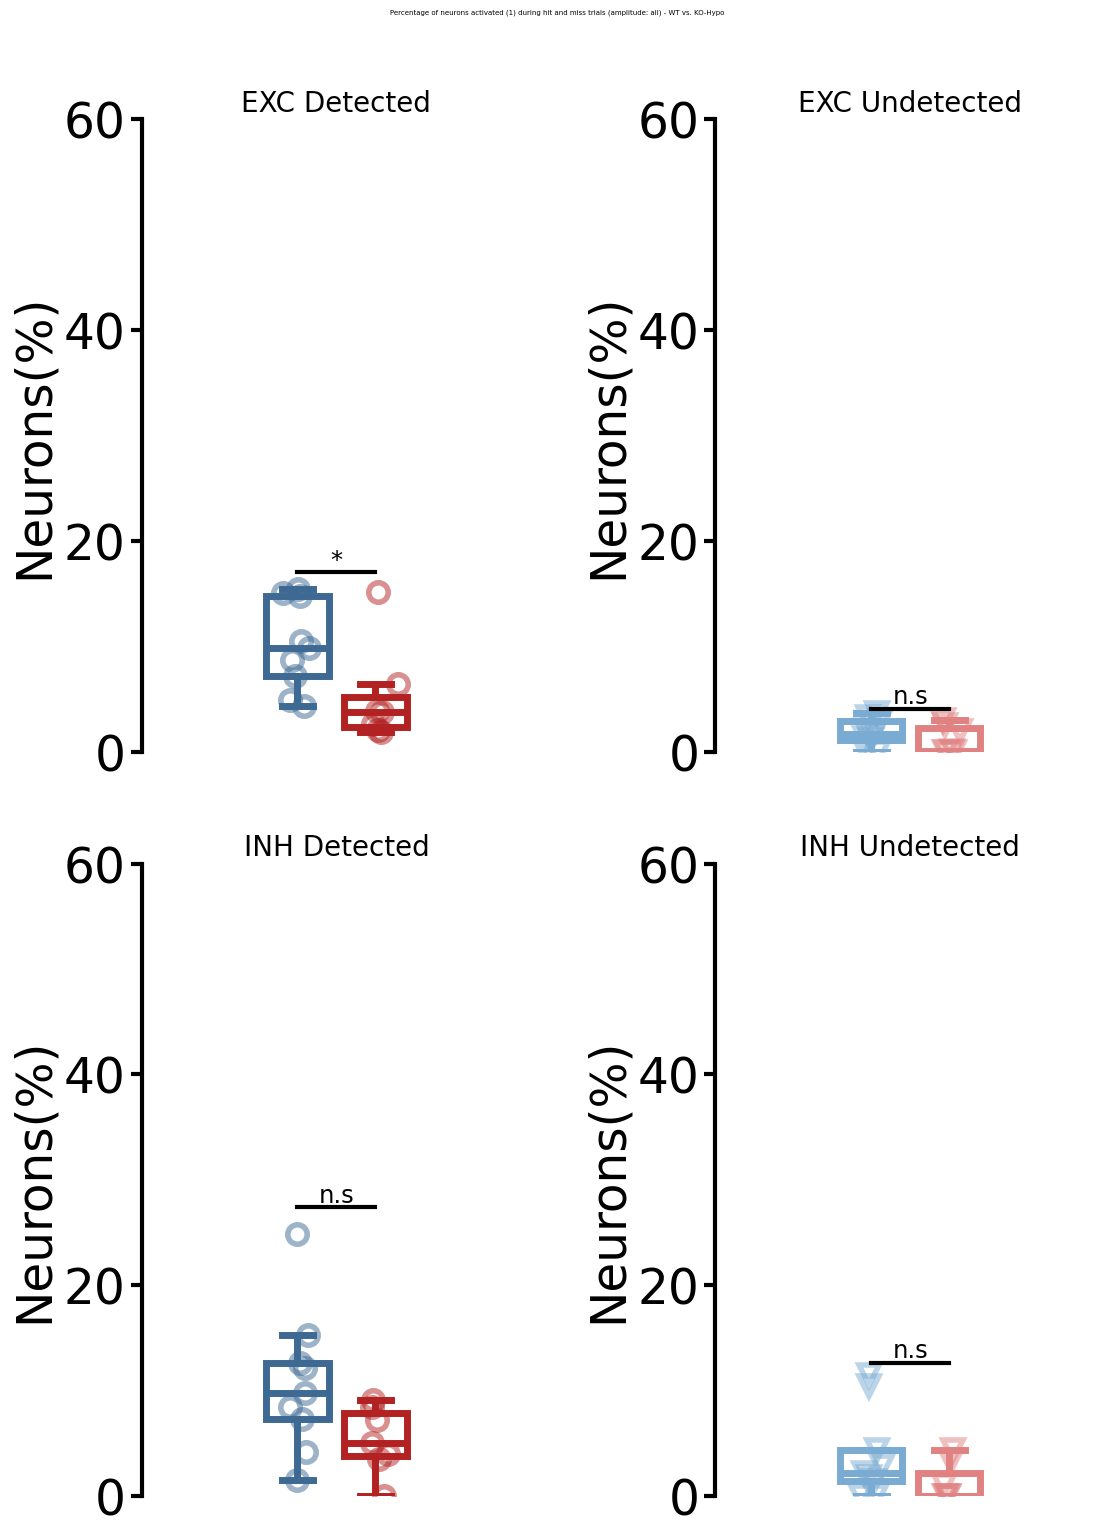

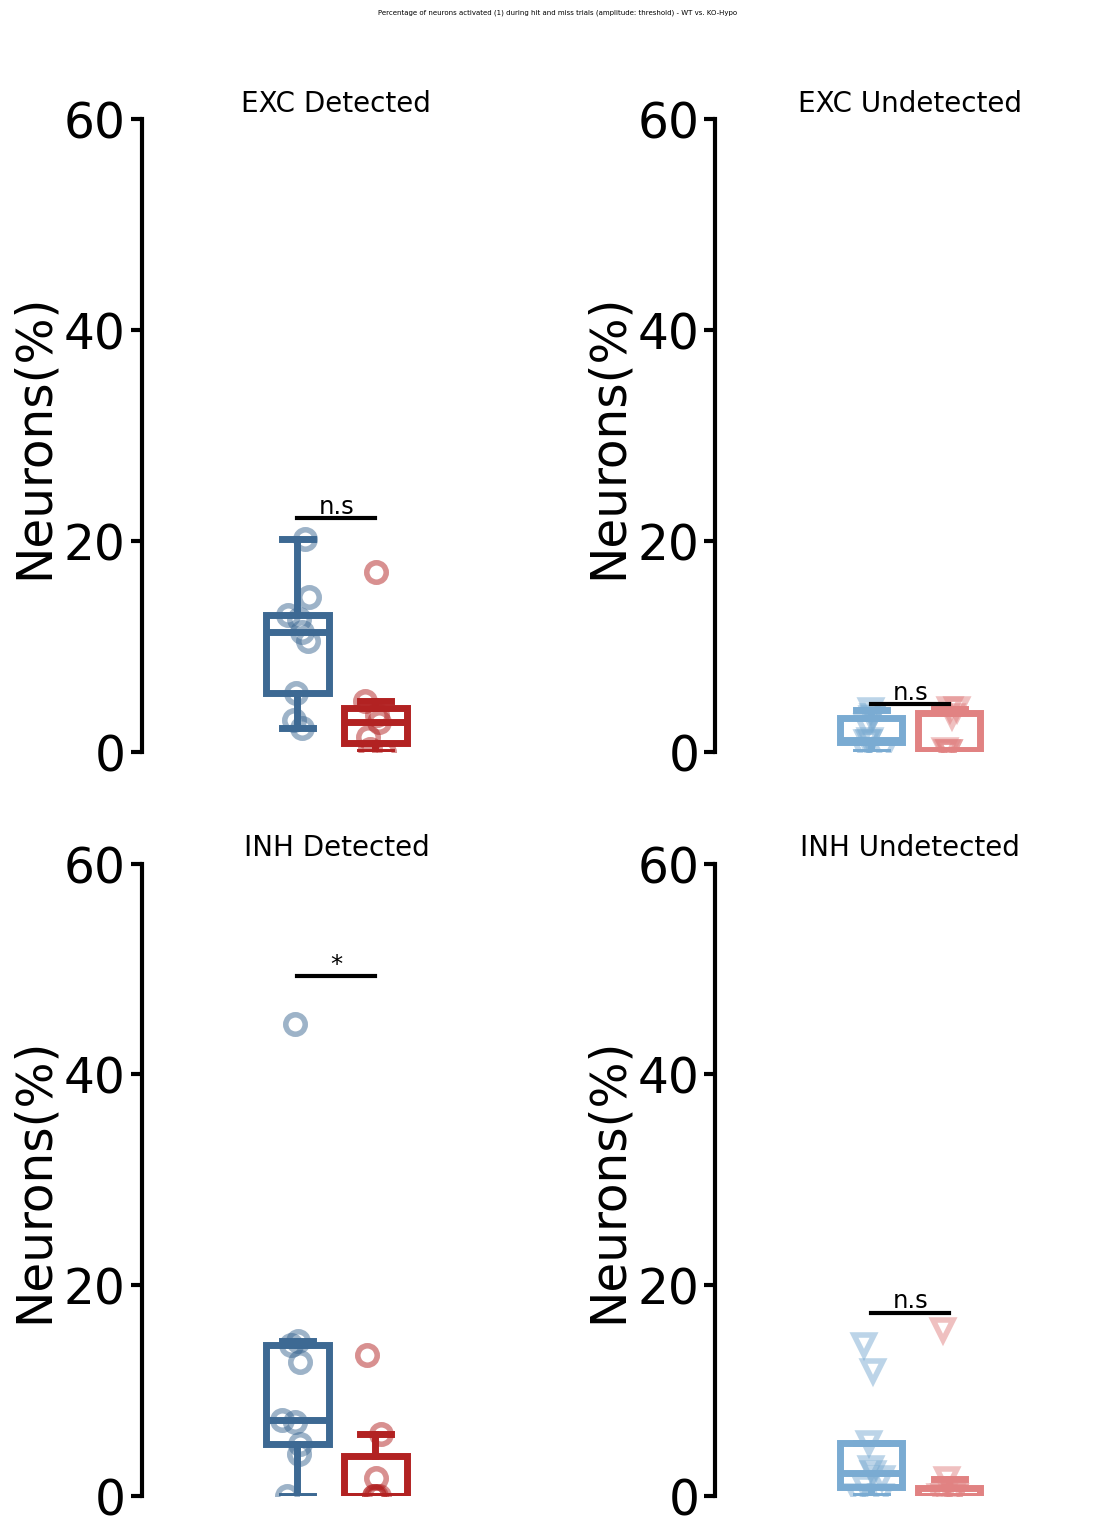

In [14]:
plot_neuron_frac_wt_ko(pattern=1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="threshold", ylim=[0, 60])

## Fraction of neurons inhibited (-1) 

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6102748028822457, pvalue=0.00012629208433269677)
ShapiroResult(statistic=0.5735739821524847, pvalue=0.00013224464652582734)
MannwhitneyuResult(statistic=44.0, pvalue=0.16160065002674062)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6817943824693956, pvalue=0.0008695833458831646)
ShapiroResult(statistic=0.7373114349746379, pvalue=0.009333056226279153)
MannwhitneyuResult(statistic=33.0, pvalue=0.9031907174005978)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7029209548342633, pvalue=0.0015351914976341014)
ShapiroResult(statistic=0.6650391046857735, pvalue=0.001520970814771864)
MannwhitneyuResult(statistic=42.0, pvalue=0.26916425146769263)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.82128561989973

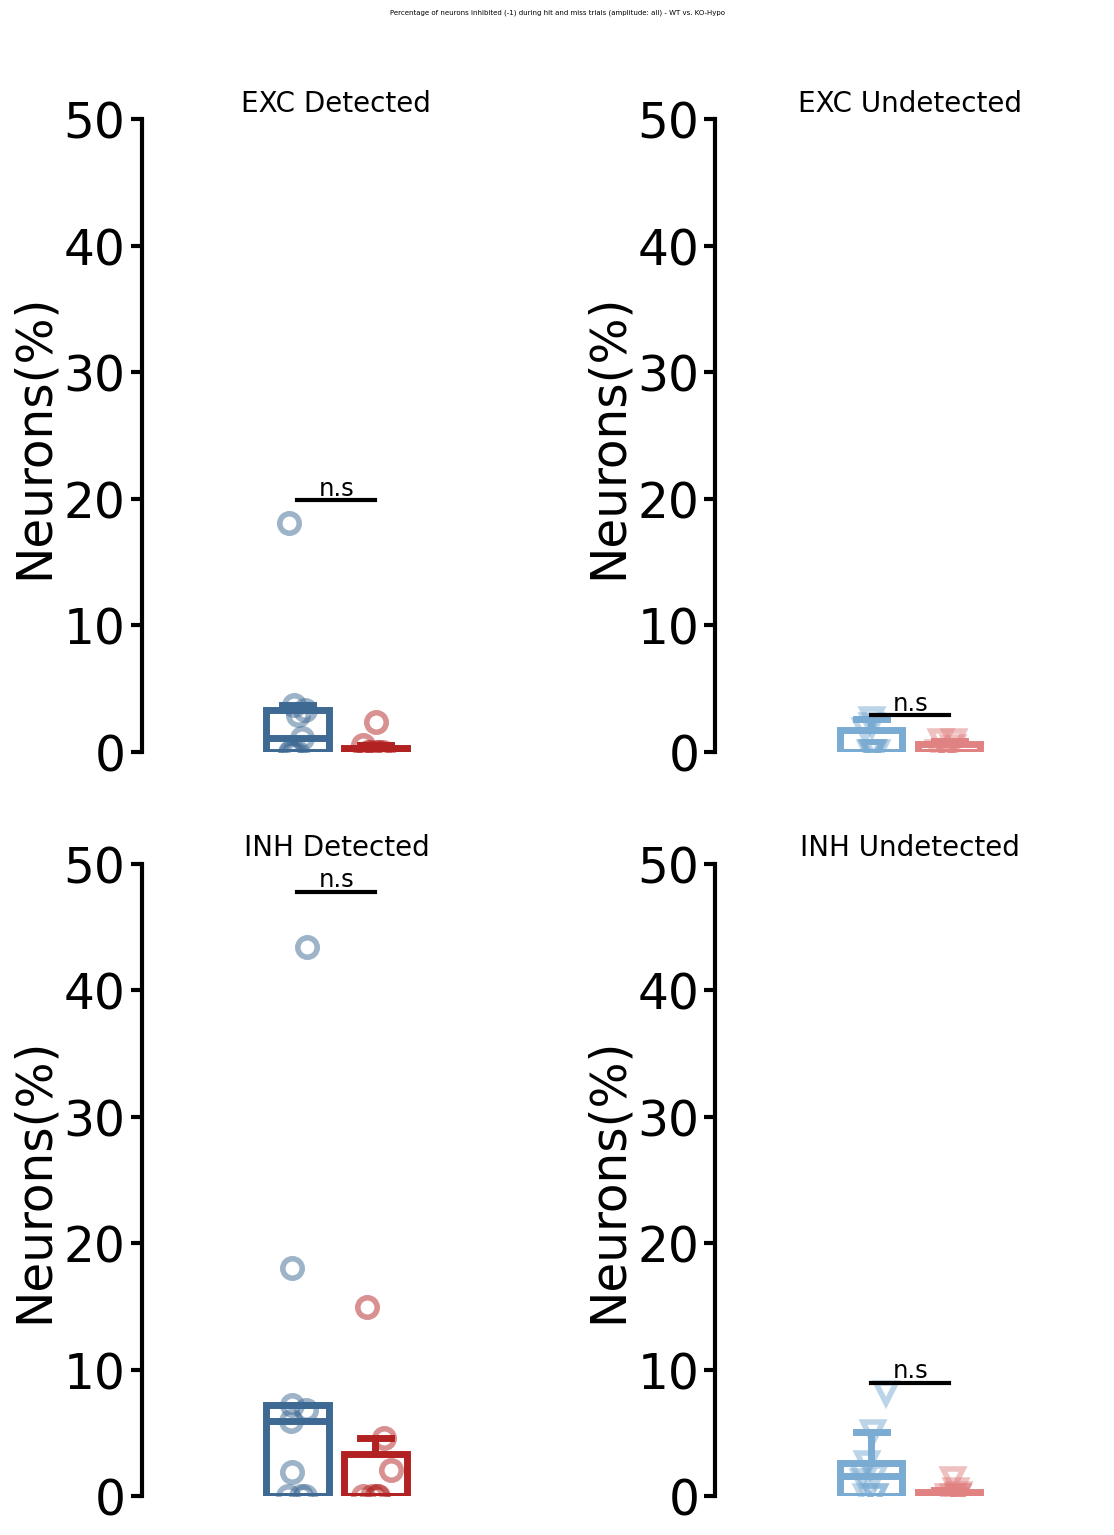

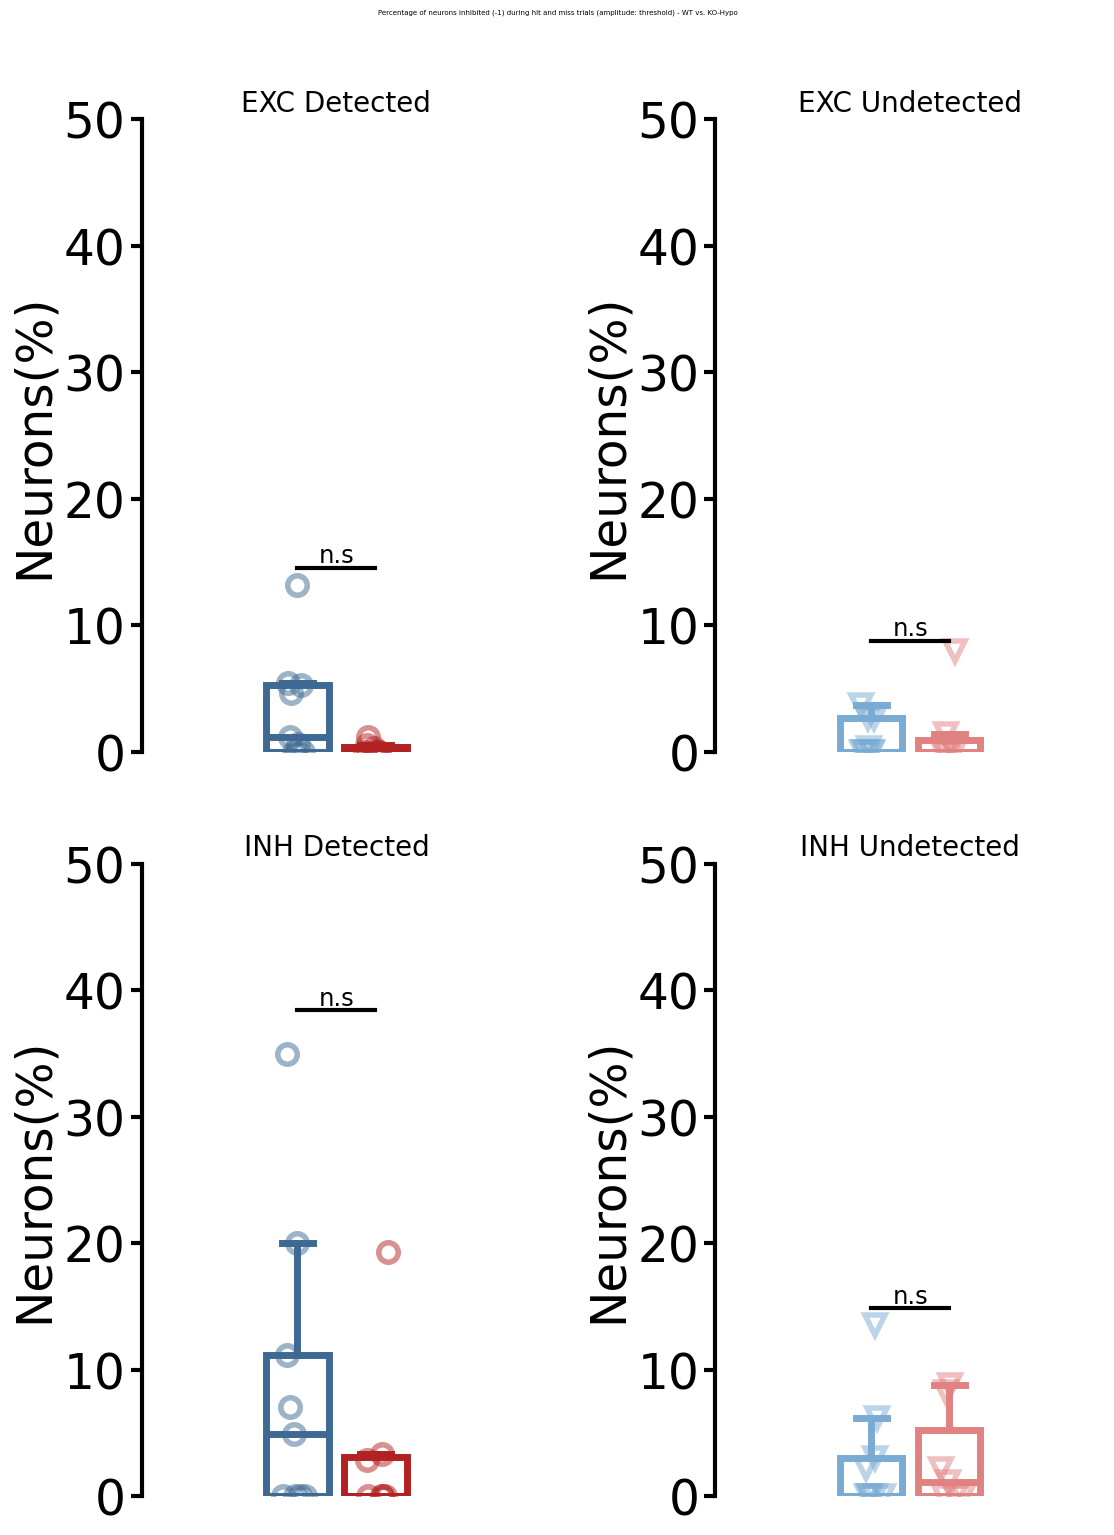

In [15]:
plot_neuron_frac_wt_ko(pattern=-1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="all", ylim=[0, 50])
plot_neuron_frac_wt_ko(pattern=-1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="threshold", ylim=[0, 50])

# Comparison group det vs group undet


## Fraction of neurons recruited (1 and -1)

In [16]:
def plot_neuron_frac_det_undet(pattern, ko_hypo_only=True, stim_ampl="all", ylim=[], no_go_normalize=True):
    if ko_hypo_only:
        ko_type = "KO-Hypo"
        color_ko = ppt.hypo_color
        light_color_ko = ppt.hypo_light_color
    else:
        ko_type = "(KO + KO-Hypo)"
        color_ko = ppt.all_ko_color
        light_color_ko = ppt.all_ko_light_color
        
    fig, axs = plt.subplots(2, 2, figsize=(12,16))
    for y_index, n_type in enumerate(["EXC", "INH"]):
        wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pattern, n_type=n_type, ko_hypo_only=ko_hypo_only, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
        ppt.boxplot(axs[y_index, 0], wt_det, wt_undet, paired=True, ylabel="Neurons(%)", title=f"{n_type} - WT", ylim=ylim, 
                    colors=[ppt.wt_color, ppt.wt_light_color])
        ppt.boxplot(axs[y_index, 1], ko_det, ko_undet, paired=True, ylabel="Neurons(%)", title=f"{n_type} - {ko_type}", ylim=ylim, 
                    colors=[color_ko, light_color_ko])

    t_pattern = "recruited (1 and -1)" if pattern == 0 else ("activated (1)" if pattern == 1 else "inhibited (-1)")
    fig.suptitle(f"Comparison of neurons {t_pattern} between hit and miss trials (amplitude: {stim_ampl}) - WT & {ko_type}", fontsize=5)
    fig.tight_layout()
    if save_figure:
        title = f"Figure2/responsivity/paired_fr_n_{t_pattern}_{stim_ampl}.pdf"
        fig.savefig(server_address + title)

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.744607973717698, pvalue=0.004694342276433134)
ShapiroResult(statistic=0.9014151664703978, pvalue=0.2603140723299354)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6986314046507984, pvalue=0.00358190264633952)
ShapiroResult(statistic=0.7501265158433752, pvalue=0.012726437168496654)
WilcoxonResult(statistic=1.0, pvalue=0.03125)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6252157278767778, pvalue=0.00018907372970499445)
ShapiroResult(statistic=0.7524694052845231, pvalue=0.005791091441077576)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8447898167838015, pvalue=0.1100662027430952)
ShapiroResult(statist

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9266728113827305, pvalue=0.450322526797605)
ShapiroResult(statistic=0.8554146495769681, pvalue=0.08545129693610179)
TtestResult(statistic=7.202734078366904, pvalue=9.220396687826092e-05, df=8)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.723177191178523, pvalue=0.00660151440865289)
ShapiroResult(statistic=0.6949753842995585, pvalue=0.0032666493932047872)
WilcoxonResult(statistic=2.0, pvalue=0.13801073756865953)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8035442690836035, pvalue=0.022413784917141175)
ShapiroResult(statistic=0.6816898543517735, pvalue=0.000867139247698085)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.759994477471055, pvalue=0.016

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


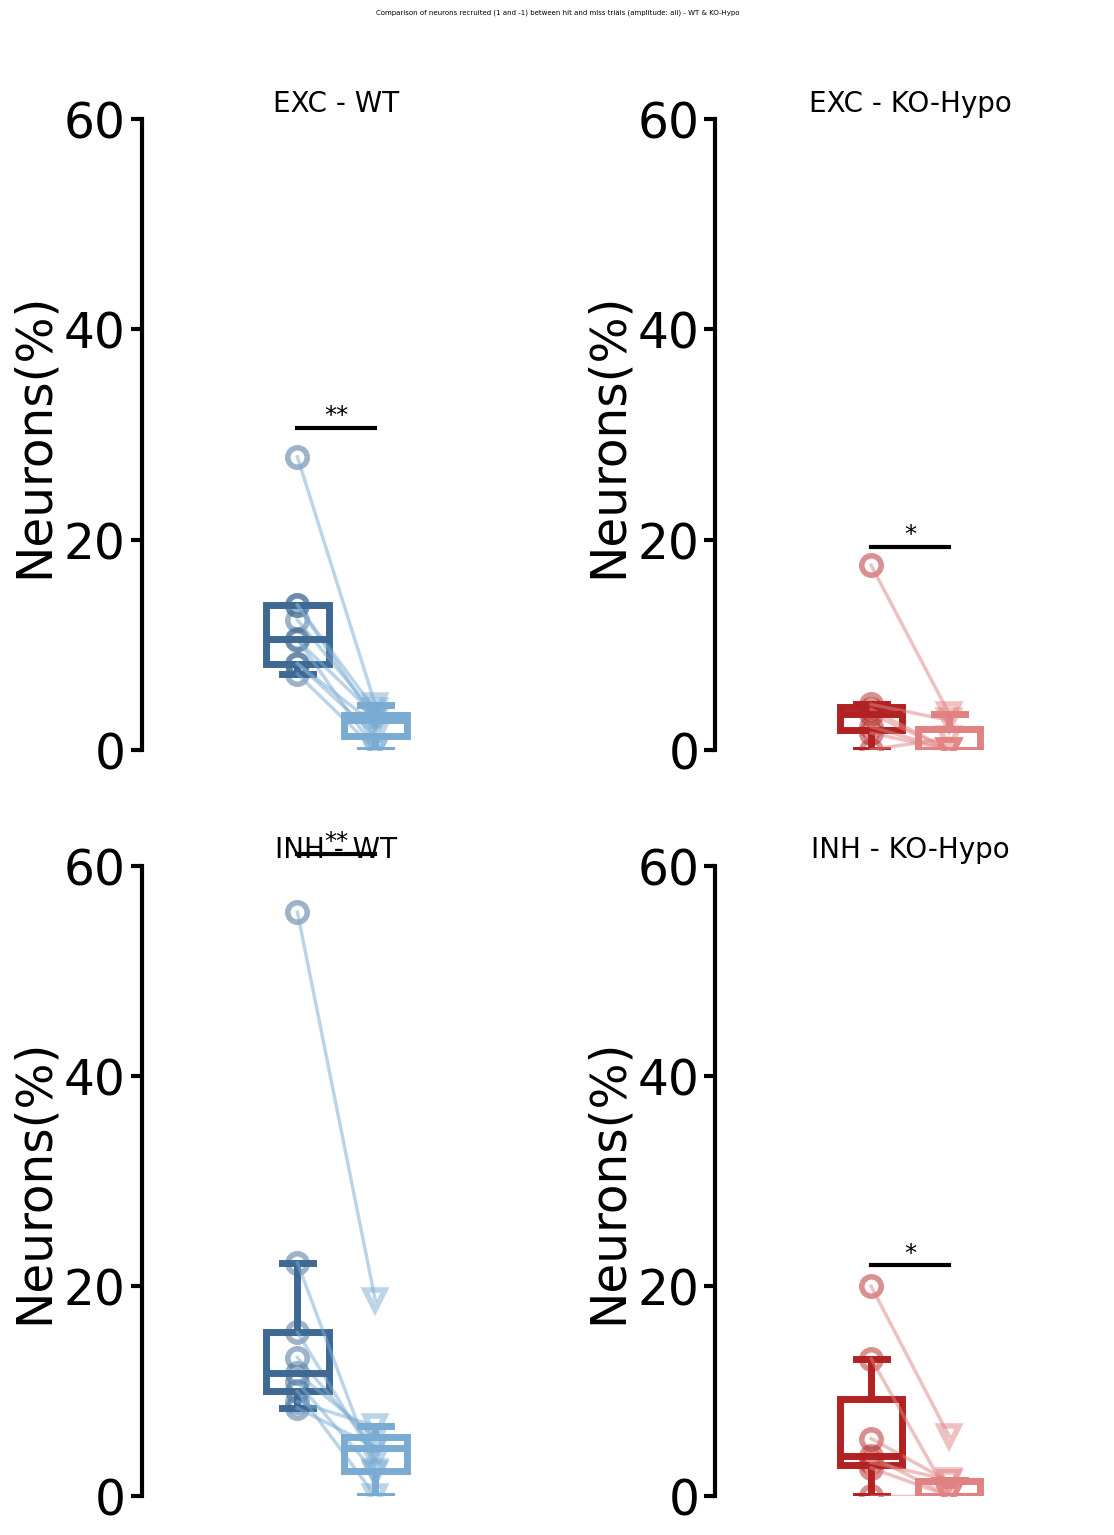

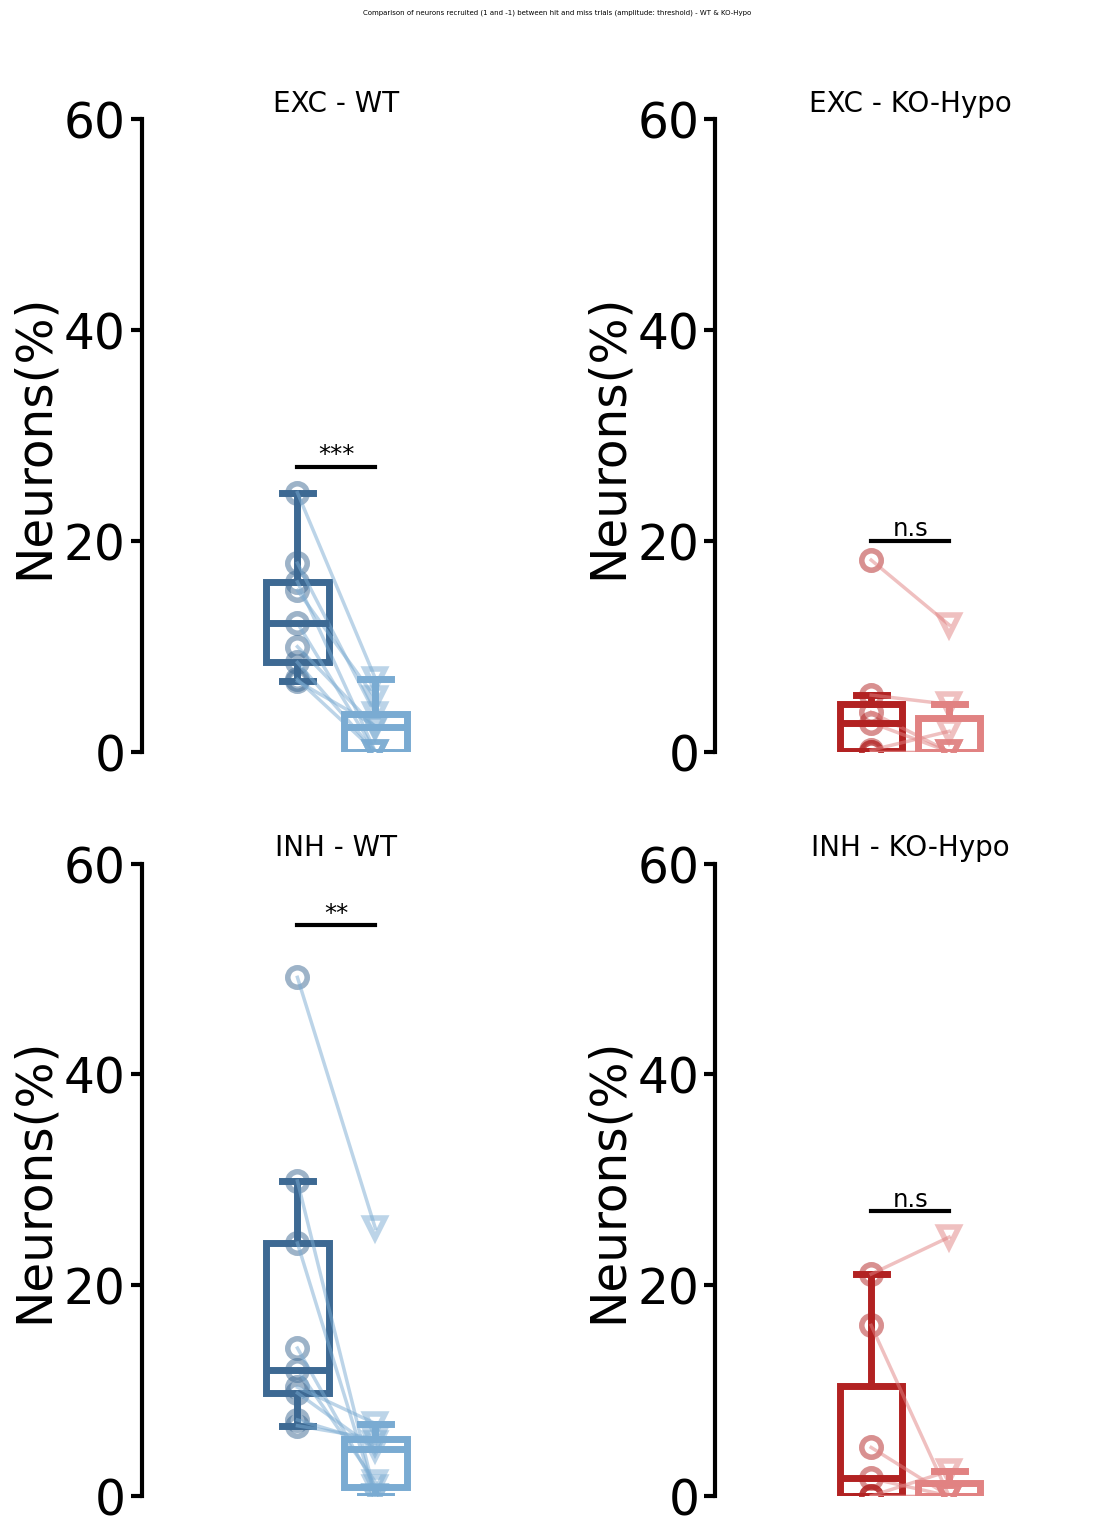

In [17]:
plot_neuron_frac_det_undet(0, ko_hypo_only=True, stim_ampl="all", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(0, ko_hypo_only=True, stim_ampl="threshold", ylim=[0,60], no_go_normalize=True)

## Fraction of neurons activated(1)

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9084076207649606, pvalue=0.3048880270822422)
ShapiroResult(statistic=0.9652264296775498, pvalue=0.851107846363746)
TtestResult(statistic=6.21754869528982, pvalue=0.0002545194131187415, df=8)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7215215282682894, pvalue=0.006337320135485719)
ShapiroResult(statistic=0.7709612112028134, pvalue=0.02089899651998921)
WilcoxonResult(statistic=1.0, pvalue=0.03125)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9448140749476439, pvalue=0.6333839709214009)
ShapiroResult(statistic=0.8060790567615318, pvalue=0.02395483305247086)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9508905857322528, pvalue=0.7377997389548656)
S

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9470162357612208, pvalue=0.657356615023396)
ShapiroResult(statistic=0.8958369096463191, pvalue=0.22884664145495154)
TtestResult(statistic=4.43902337828616, pvalue=0.0021707658634296883, df=8)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7248728625260197, pvalue=0.006883094865124891)
ShapiroResult(statistic=0.7170180937112044, pvalue=0.00566930953106192)
WilcoxonResult(statistic=3.0, pvalue=0.11585149752593006)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7448050828374273, pvalue=0.004719138537459674)
ShapiroResult(statistic=0.7879391042623267, pvalue=0.014859614979421567)
WilcoxonResult(statistic=1.0, pvalue=0.017290280592906253)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7000691081499216, pv

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


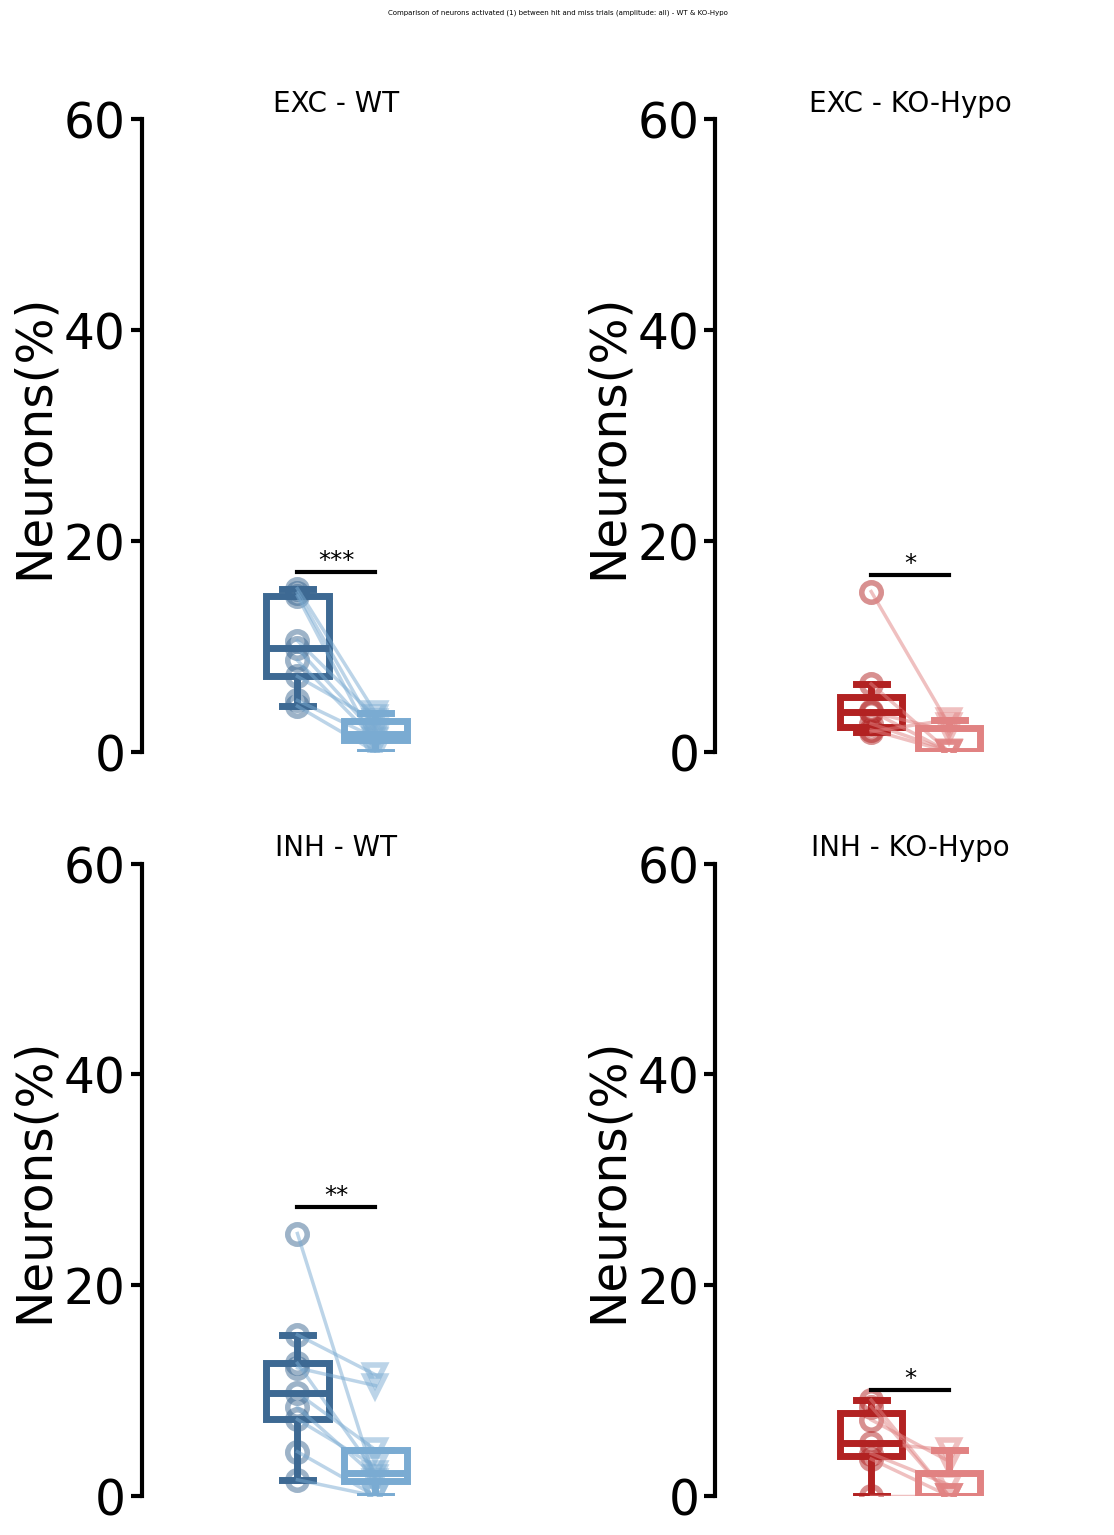

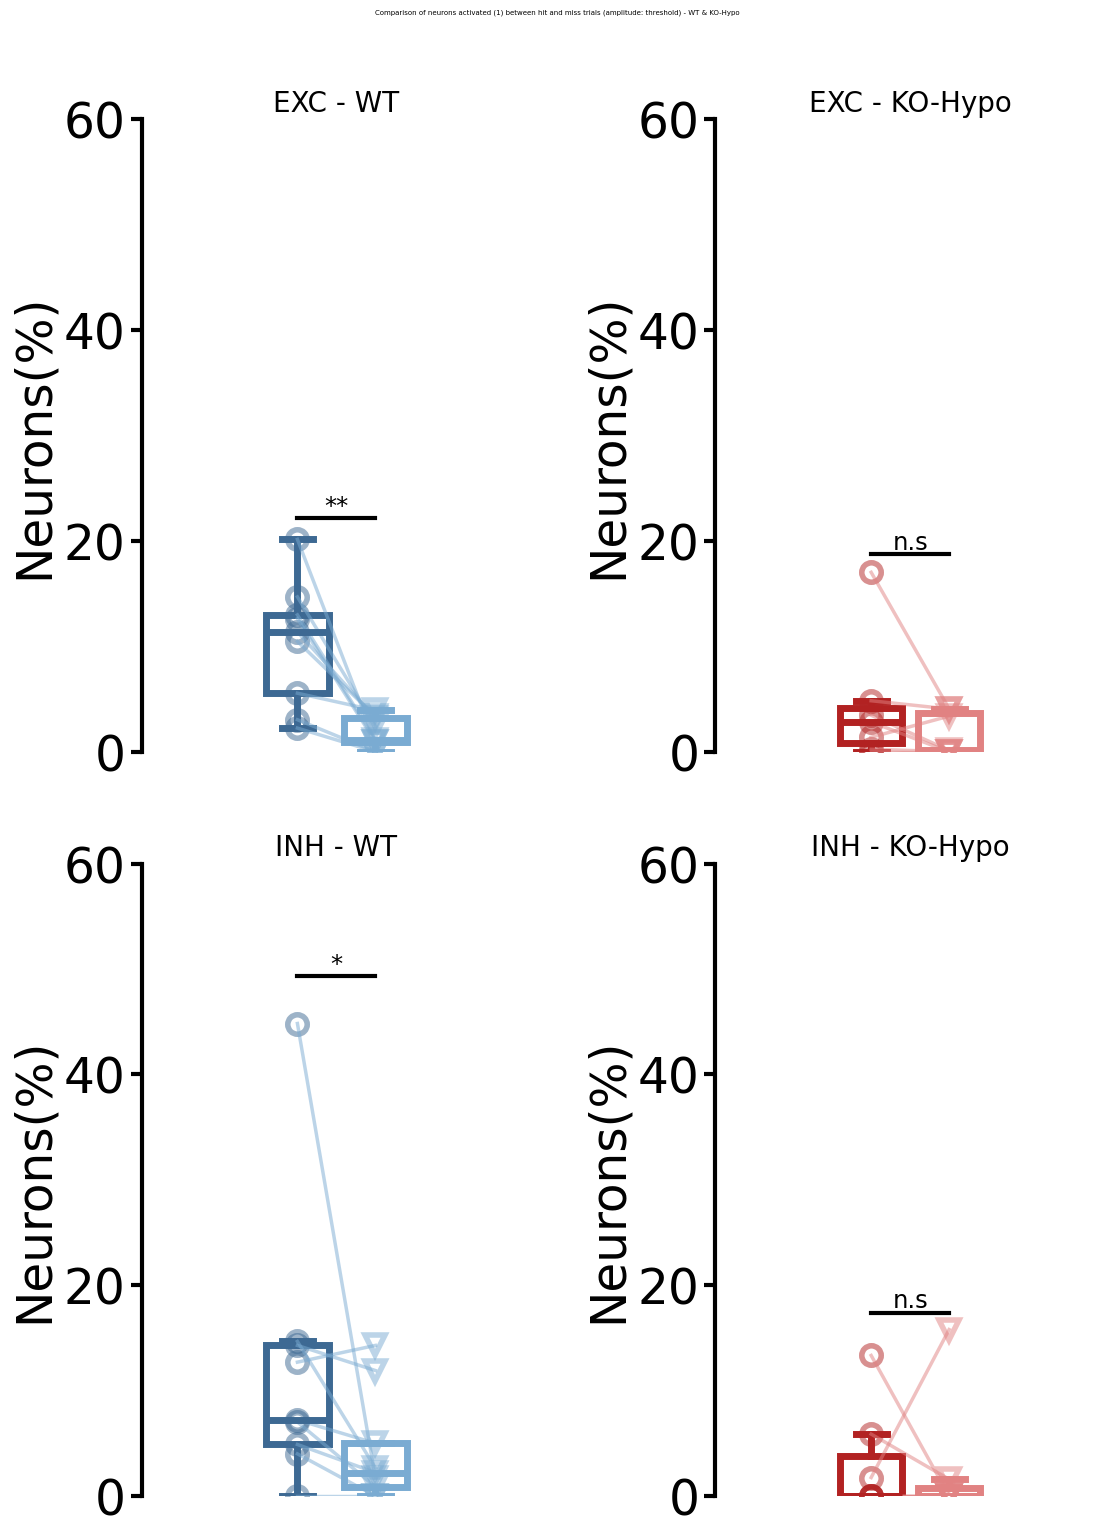

In [18]:
plot_neuron_frac_det_undet(1, ko_hypo_only=True, stim_ampl="all", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(1, ko_hypo_only=True, stim_ampl="threshold", ylim=[0,60], no_go_normalize=True)

## Fraction of neurons inhibited (-1)

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6102748028822457, pvalue=0.00012629208433269677)
ShapiroResult(statistic=0.6817943824693956, pvalue=0.0008695833458831646)
WilcoxonResult(statistic=3.0, pvalue=0.11585149752593006)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5735739821524847, pvalue=0.00013224464652582734)
ShapiroResult(statistic=0.7373114349746379, pvalue=0.009333056226279153)
WilcoxonResult(statistic=3.0, pvalue=1.0)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7029209548342633, pvalue=0.0015351914976341014)
ShapiroResult(statistic=0.8212856198997307, pvalue=0.03562929377042209)
WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6650391046857735, pvalue=0.001520970814771864)
ShapiroResult(statistic=0.6916507260685851, pvalue=0.003003417828309057)
WilcoxonResult(statistic=3.0, pvalue=0.22491588401596185)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7863099580141042, pvalue=0.014233356314982957)
ShapiroResult(statistic=0.7118914973477619, pvalue=0.001953590696264547)
WilcoxonResult(statistic=2.0, pvalue=0.07473549830588248)
Boxplot plotting.


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


--- Neurons(%) ---
ShapiroResult(statistic=0.7428882126439293, pvalue=0.010686420381182461)
ShapiroResult(statistic=0.5723020602797488, pvalue=0.00012768562677687248)
WilcoxonResult(statistic=3.0, pvalue=0.4652088184521418)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7840467872951555, pvalue=0.013406371712616837)
ShapiroResult(statistic=0.699267323698578, pvalue=0.0013915668613316036)
WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6041891701342363, pvalue=0.00030486159929392684)
ShapiroResult(statistic=0.74408576927808, pvalue=0.011000722630984021)
WilcoxonResult(statistic=5.0, pvalue=0.5001842570707944)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


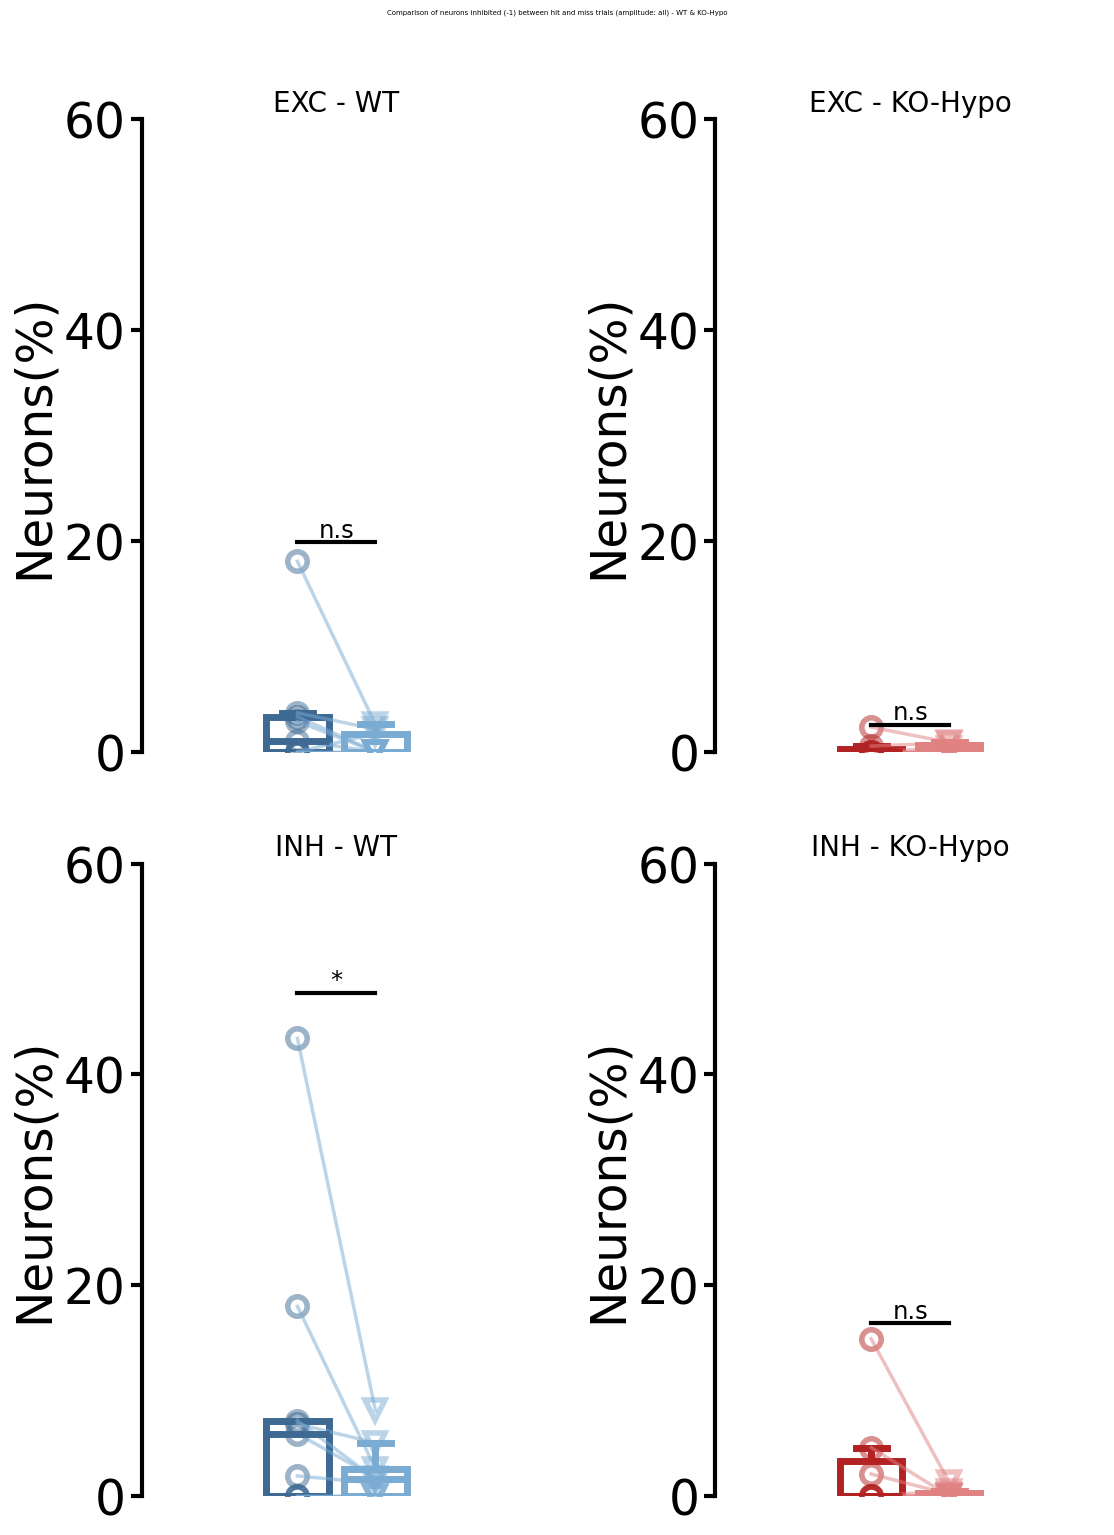

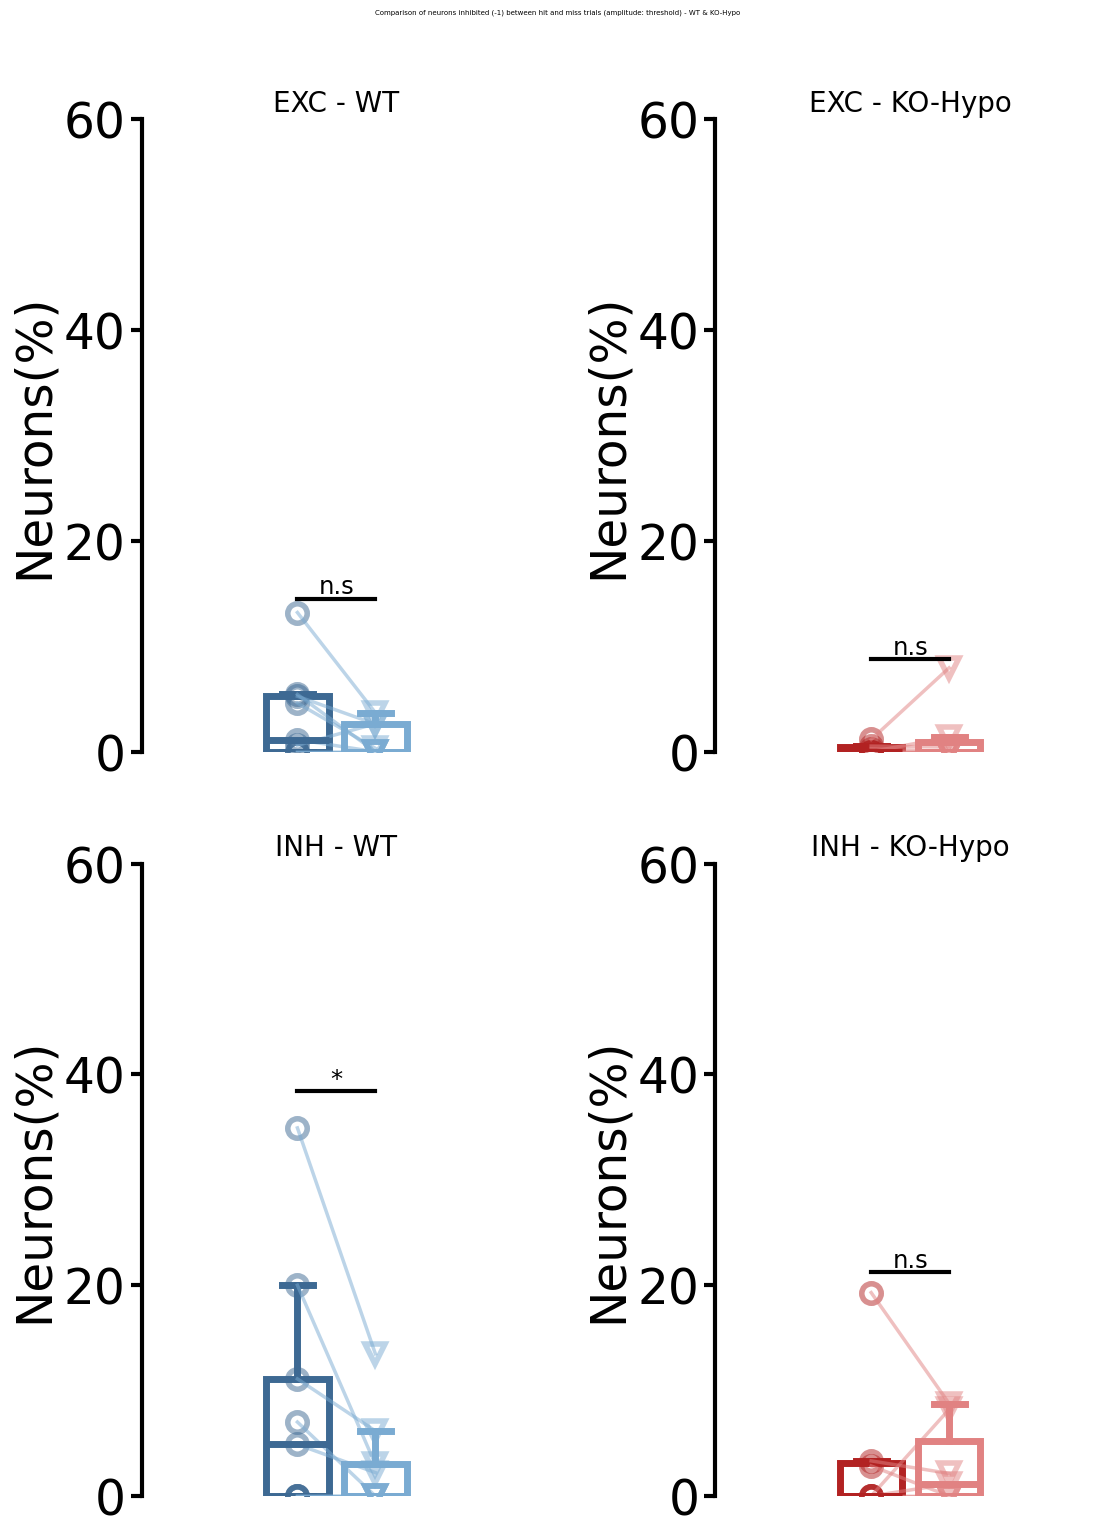

In [19]:
plot_neuron_frac_det_undet(-1, ko_hypo_only=True, stim_ampl="all", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(-1, ko_hypo_only=True, stim_ampl="threshold", ylim=[0,60], no_go_normalize=True)

# Responsivity contrast between det and undet trials

## Ratio

### responsivity contrast of neurons recruited

In [20]:
def resp_contrast(pattern="recruited", stim_ampl="all", method="ratio", ylim=[]):
    pat_dict = {"recruited": 0, "activated": 1, "inhibited": -1}
    fig, axs = plt.subplots(1,2,figsize=(12,8))
    for i, type in enumerate(["EXC", "INH"]):
        wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pat_dict[pattern], n_type=type, ko_hypo_only=True, stim_ampl=stim_ampl)
        if method == "ratio":
            wt_nan = np.logical_and(wt_det>0, wt_undet>0)
            ko_nan = np.logical_and(ko_det>0, ko_undet>0)
            wt_det, ko_det, wt_undet, ko_undet = wt_det[wt_nan], ko_det[ko_nan], wt_undet[wt_nan], ko_undet[ko_nan]
            wt = wt_det/wt_undet
            ko = ko_det/ko_undet
        elif method == "delta":
            wt = wt_det - wt_undet
            ko = ko_det - ko_undet
        ppt.boxplot(axs[i], wt, ko, ylabel=f"{method} nb neuron Hit/Miss", paired=False, ylim=ylim)
        fig.suptitle(f"Comparaison of {method} of {pattern} neurons between detected and undetected trials for {stim_ampl} stimulus", fontsize=10)
    fig.tight_layout()
    if save_figure:
        fig.savefig(server_address + f"Figure2/responsivity/contrast_resp_{method}({pattern})_{stim_ampl}.pdf")
    plt.show()

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.83558079047762, pvalue=0.06782589256632245)
ShapiroResult(statistic=0.9333807655328034, pvalue=0.5014076971787271)
LeveneResult(statistic=0.7448356415016154, pvalue=0.41052431806796524)
Equal variances :TtestResult(statistic=0.33236840463065037, pvalue=0.7472214164086698, df=9.0)


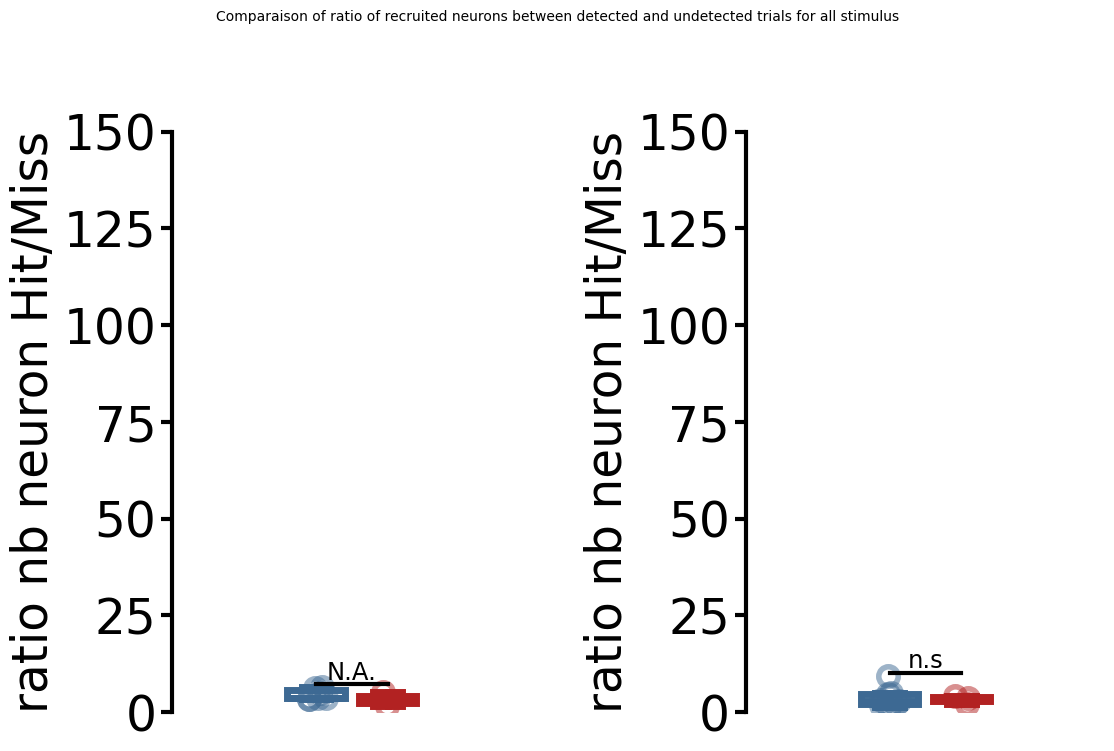

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.9488523366652104, pvalue=0.7289869476016704)
ShapiroResult(statistic=0.9053760943467948, pvalue=0.40282479192529475)
LeveneResult(statistic=0.33662756369638624, pvalue=0.5828991243025987)
Equal variances :TtestResult(statistic=4.335560818066477, pvalue=0.004898919229685547, df=6.0)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.


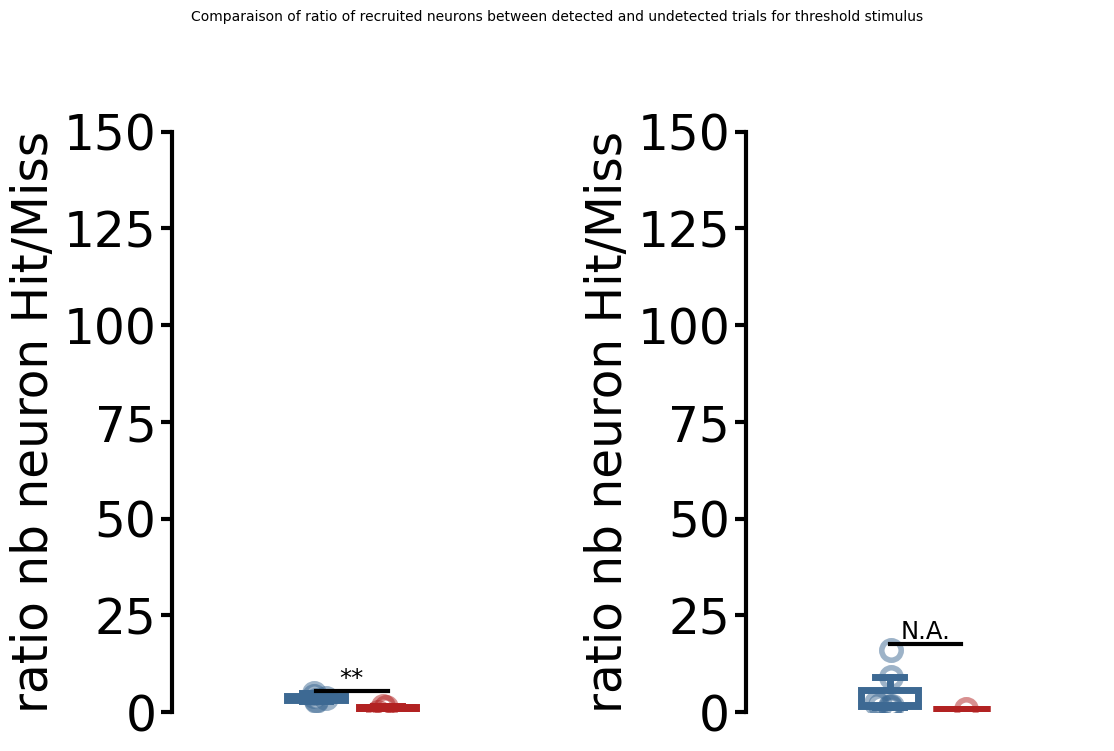

In [21]:
resp_contrast(pattern="recruited", stim_ampl="all", method="ratio", ylim=[0, 150])
resp_contrast(pattern="recruited", stim_ampl="threshold", method="ratio", ylim=[0, 150])

### responsivity contrast of neurons activated

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.6549073087399833, pvalue=0.0006891627411582604)
ShapiroResult(statistic=0.777572872507255, pvalue=0.06770708098663827)
MannwhitneyuResult(statistic=19.0, pvalue=0.6828282828282828)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.6968978791321638, pvalue=0.0034289161298002168)
ShapiroResult(statistic=0.9843366094095868, pvalue=0.7603460514395741)
MannwhitneyuResult(statistic=15.0, pvalue=0.3833333333333333)


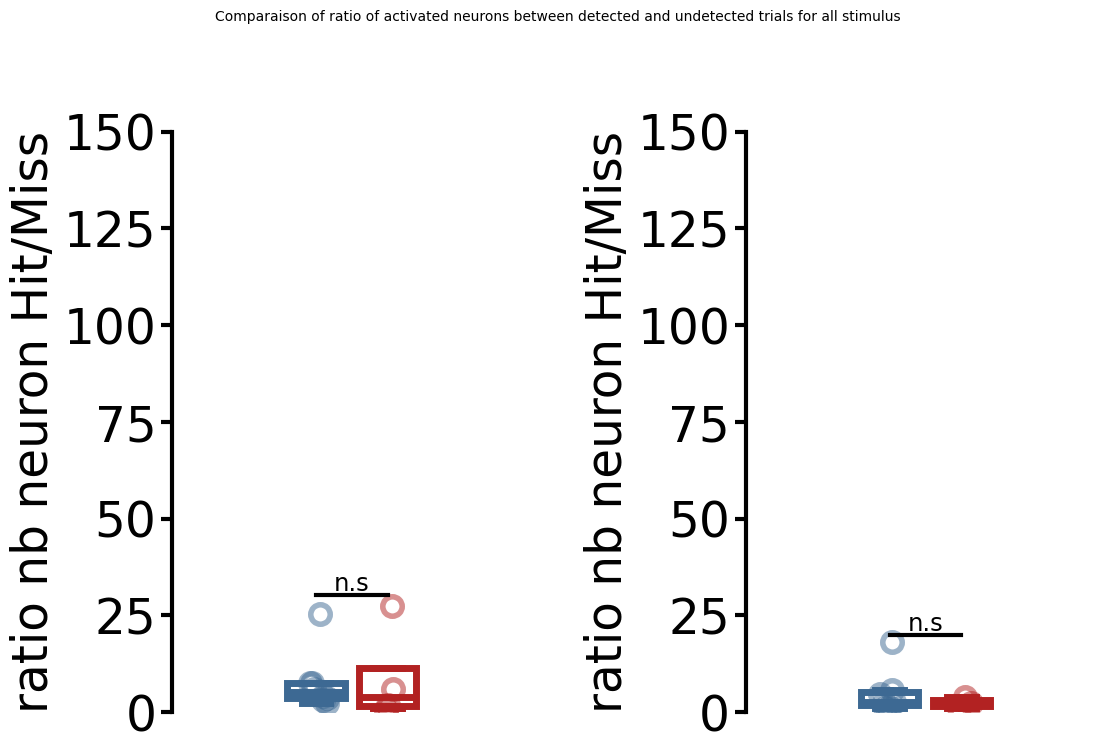

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.896361414710123, pvalue=0.3095151522714751)
ShapiroResult(statistic=0.7362881952103653, pvalue=0.028495917172996675)
MannwhitneyuResult(statistic=18.0, pvalue=0.5272727272727272)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.


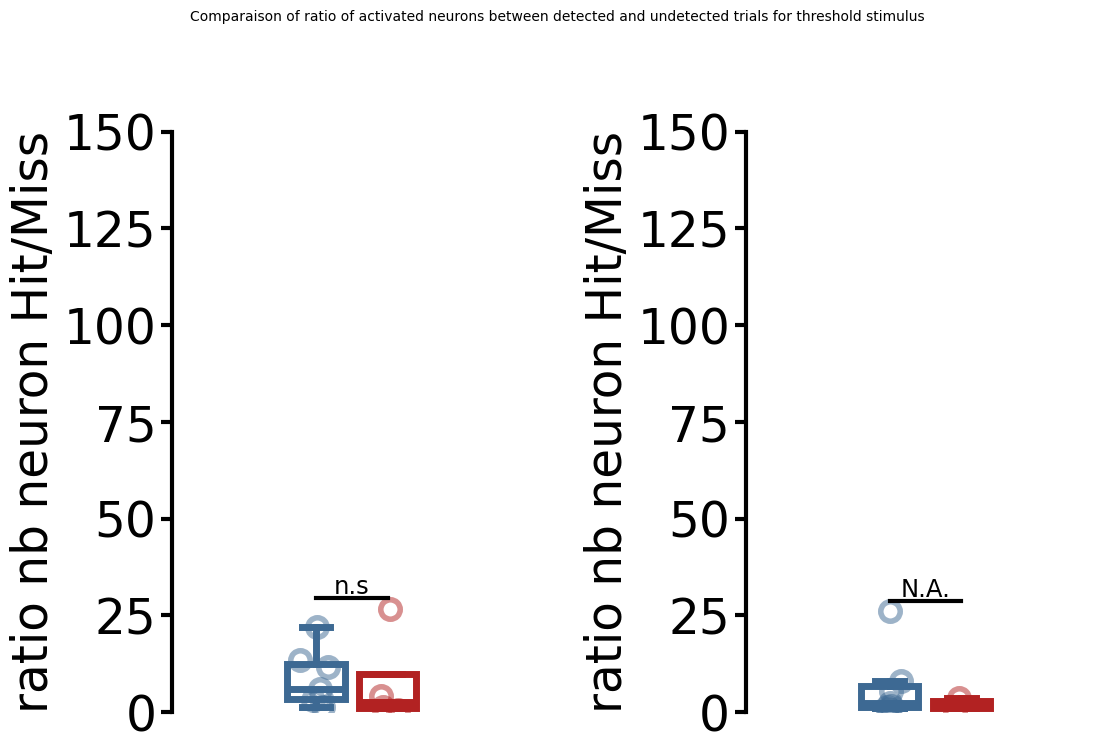

In [22]:
resp_contrast(pattern="activated", stim_ampl="all", method="ratio", ylim=[0, 150])
resp_contrast(pattern="activated", stim_ampl="threshold", method="ratio", ylim=[0, 150])

### responsivity contrast of neurons inhibited


4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.


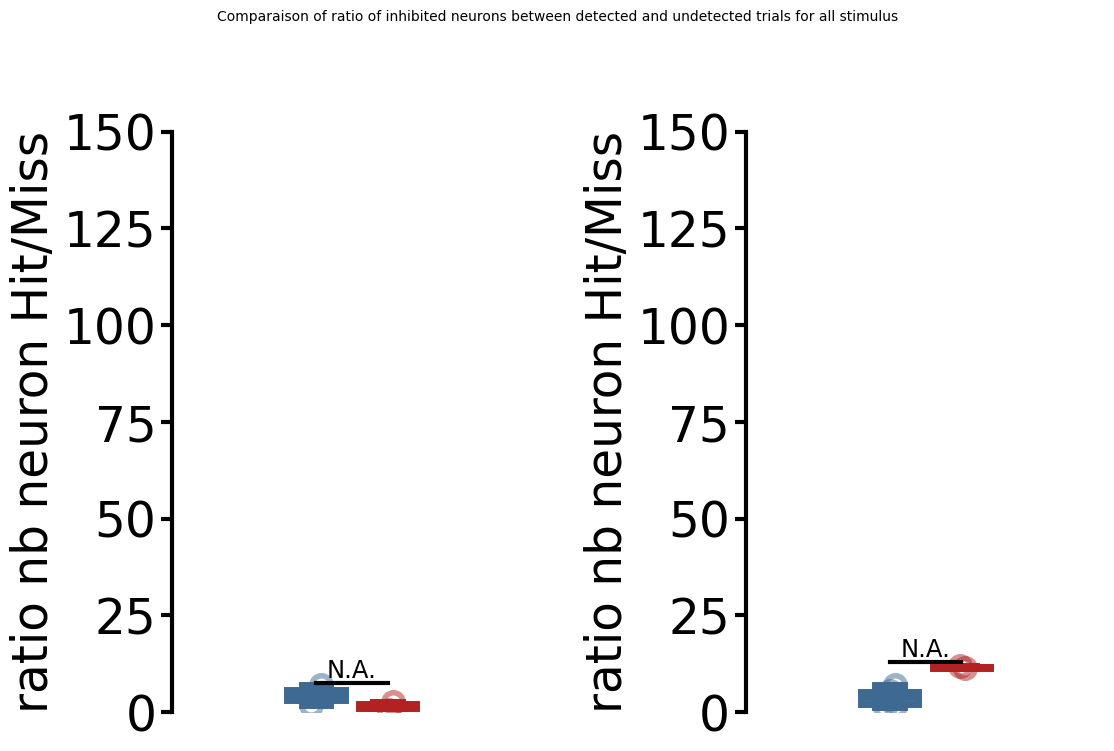

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.


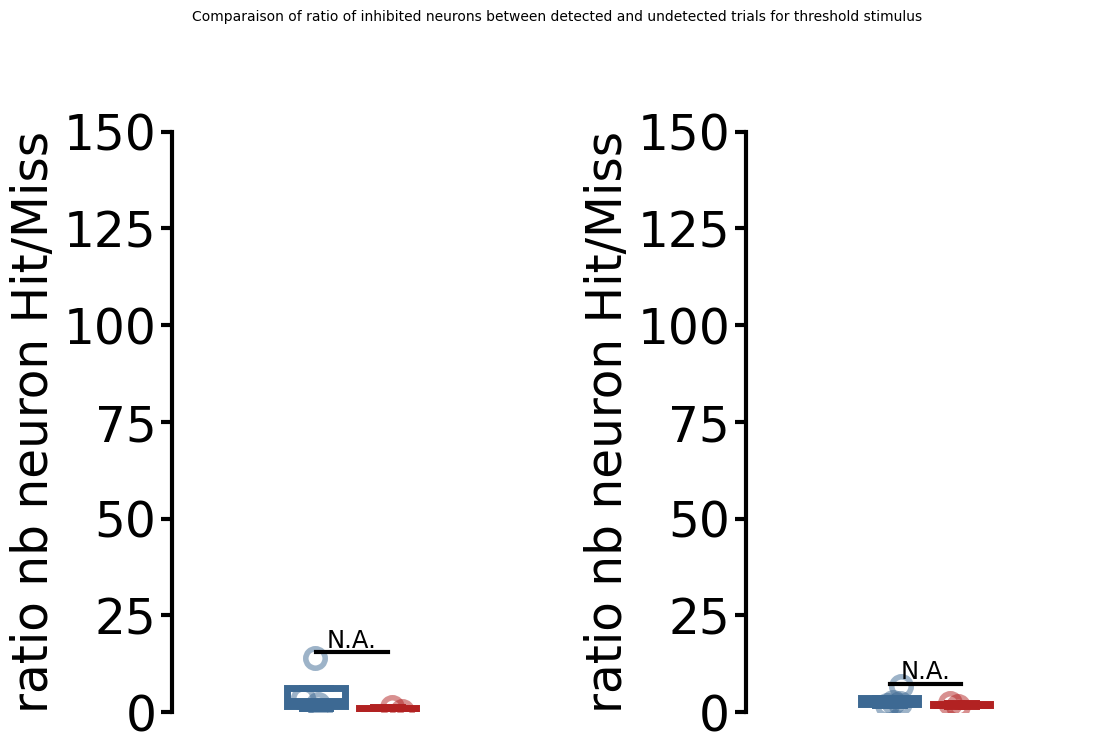

In [23]:
resp_contrast(pattern="inhibited", stim_ampl="all", method="ratio", ylim=[0, 150])
resp_contrast(pattern="inhibited", stim_ampl="threshold", method="ratio", ylim=[0, 150])

## Delta

### Recruited

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7044096700997655, pvalue=0.0015978646044540296)
ShapiroResult(statistic=0.7612047850908157, pvalue=0.016588691887490153)
MannwhitneyuResult(statistic=55.0, pvalue=0.011538461538461539)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.798591127263497, pvalue=0.01967820533265948)
ShapiroResult(statistic=0.8204593773407816, pvalue=0.06487453258818701)
MannwhitneyuResult(statistic=44.0, pvalue=0.2104895104895105)


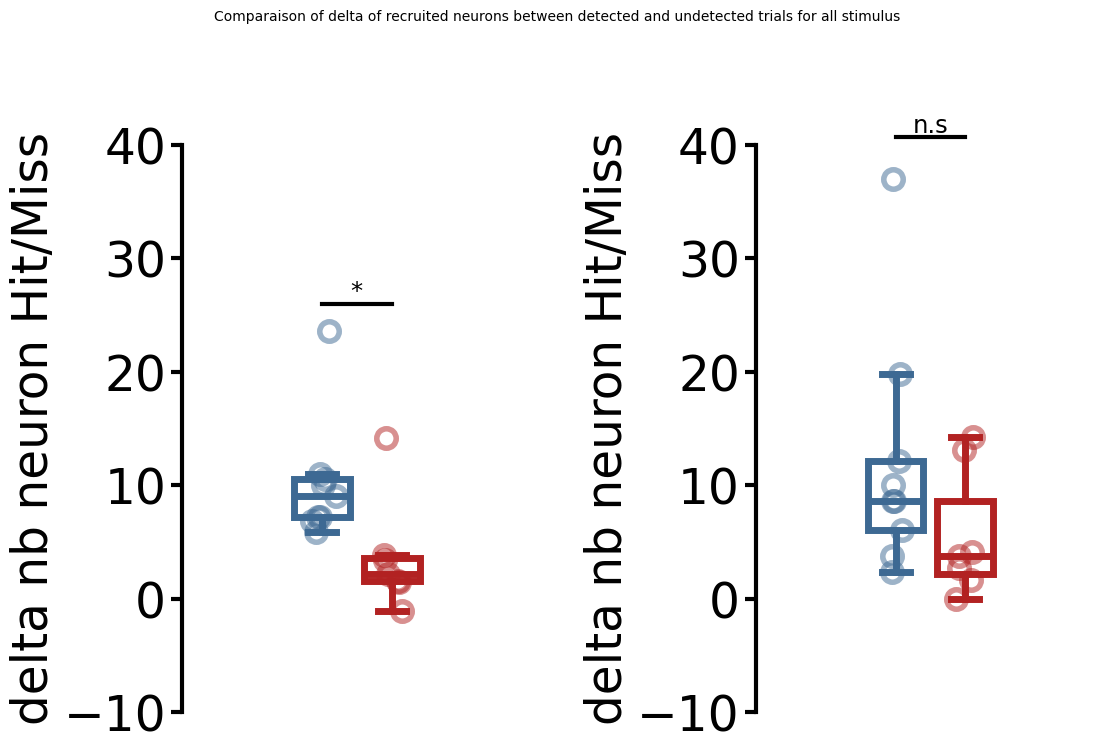

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.9647788284354141, pvalue=0.8467635077951525)
ShapiroResult(statistic=0.9576039198518356, pvalue=0.7979340218105199)
LeveneResult(statistic=2.221405060453651, pvalue=0.15829237699084567)
Equal variances :TtestResult(statistic=4.733119530962447, pvalue=0.00032049506636687127, df=14.0)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.8842920390908595, pvalue=0.17414228454280373)
ShapiroResult(statistic=0.8077242283922211, pvalue=0.048802189519299155)
MannwhitneyuResult(statistic=53.0, pvalue=0.026114016497198137)


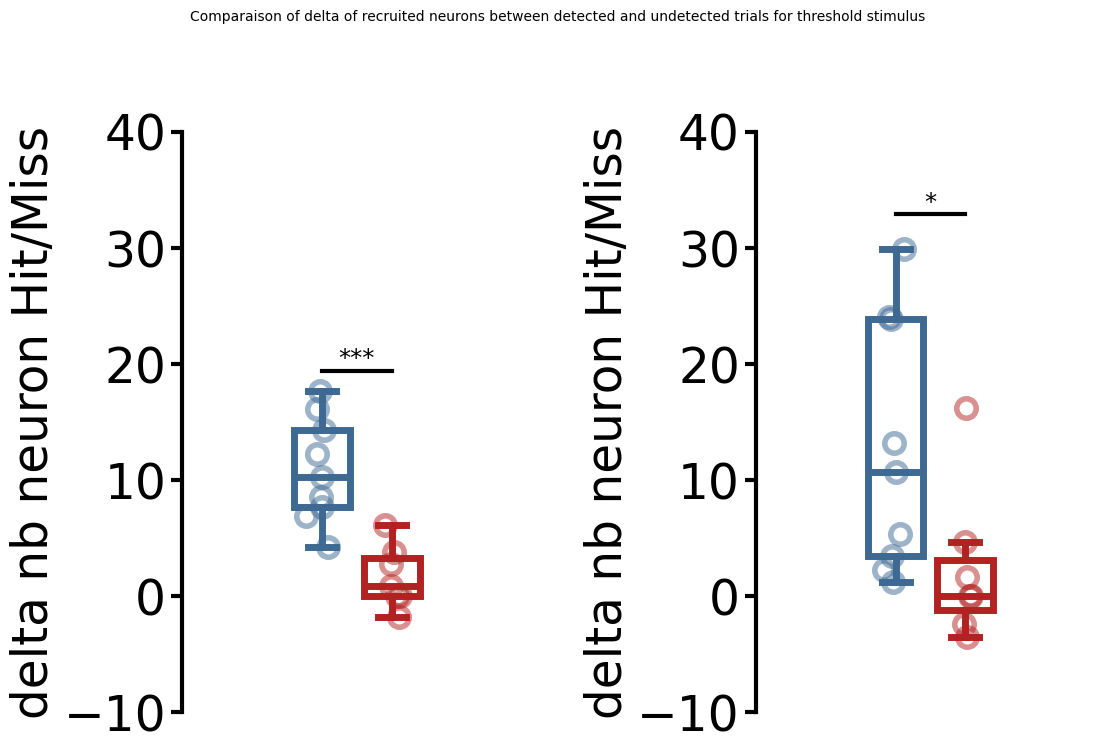

In [24]:
resp_contrast(pattern="recruited", stim_ampl="all", method="delta", ylim=[-10, 40])
resp_contrast(pattern="recruited", stim_ampl="threshold", method="delta", ylim=[-10, 40])

### Activated

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.9067911607361343, pvalue=0.2940573262334122)
ShapiroResult(statistic=0.8915358567766354, pvalue=0.2827712287360992)
LeveneResult(statistic=0.017809627243167182, pvalue=0.8957346823238314)
Equal variances :TtestResult(statistic=1.989357008015783, pvalue=0.06656593646305854, df=14.0)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7297563612083958, pvalue=0.003154719239103705)
ShapiroResult(statistic=0.8980515895184306, pvalue=0.3193457874148993)
MannwhitneyuResult(statistic=42.0, pvalue=0.29912587412587416)


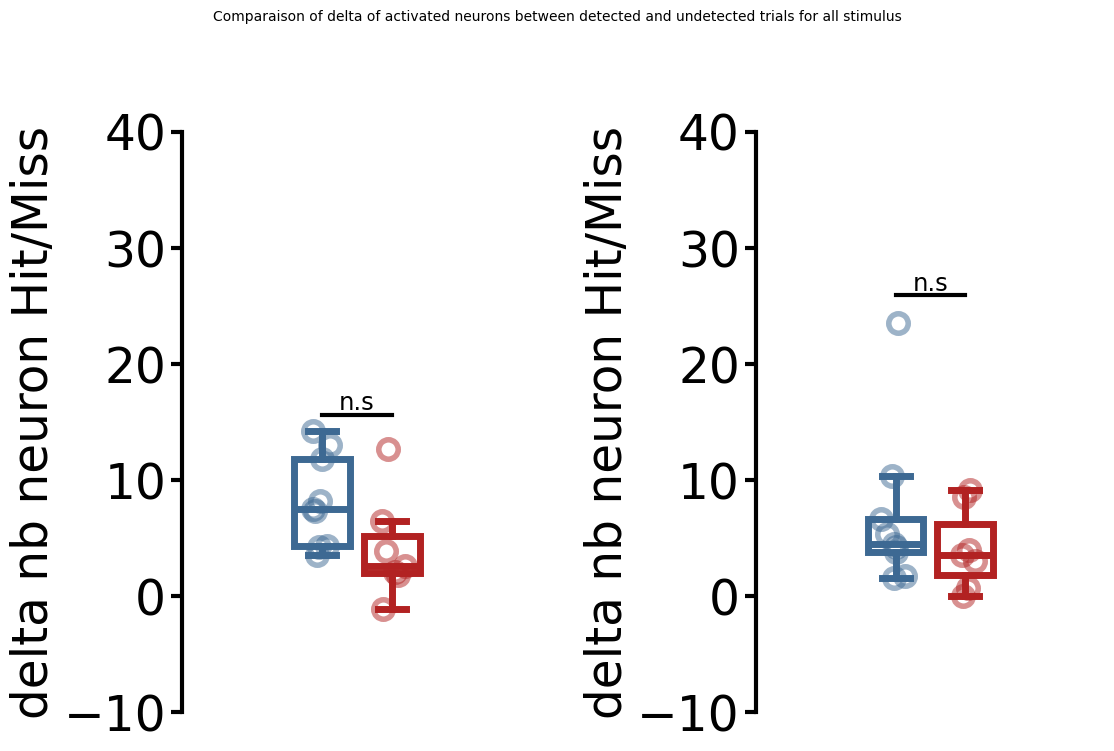

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.927116712767862, pvalue=0.454384308428576)
ShapiroResult(statistic=0.7911956493016268, pvalue=0.03348345252287747)
MannwhitneyuResult(statistic=50.0, pvalue=0.0548951048951049)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.6388410029525702, pvalue=0.0002731337306589645)
ShapiroResult(statistic=0.86073202212217, pvalue=0.15369136348904522)
MannwhitneyuResult(statistic=43.0, pvalue=0.23725582662349487)


C:\Users\cvandromme\PycharmProjects\Percephone\percephone\plts\stats.py:118: UserWarning: The ylim you have set don't cover the data range.
  warnings.warn("The ylim you have set don't cover the data range.")


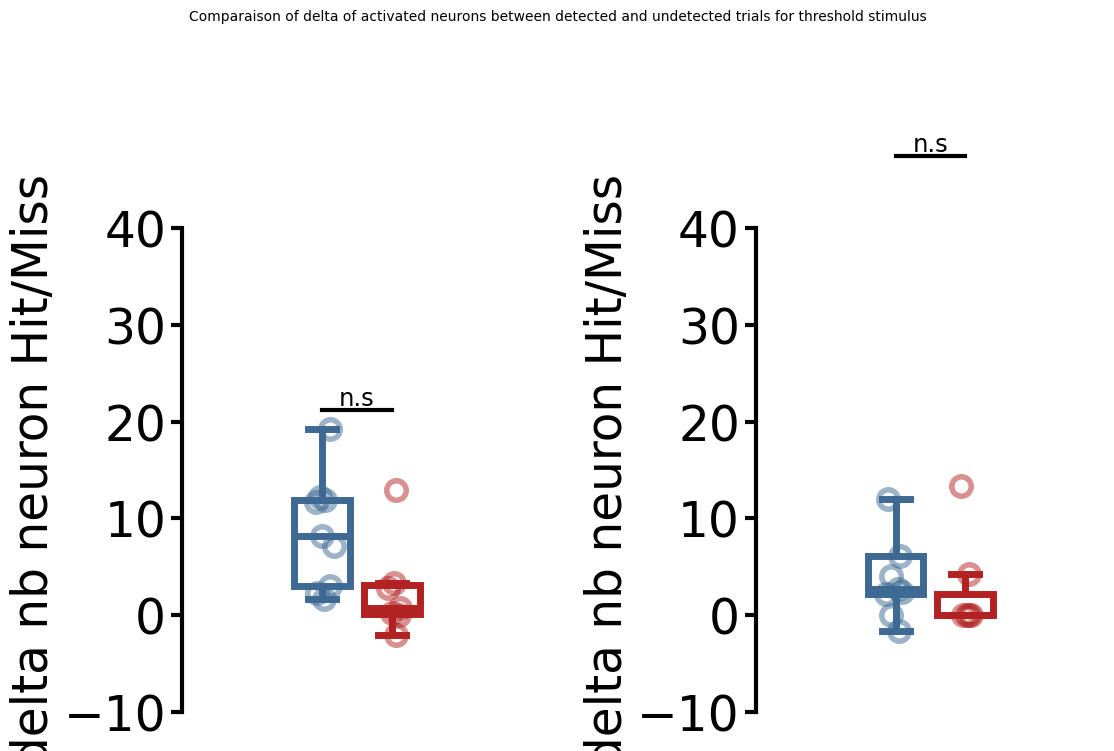

In [25]:
resp_contrast(pattern="activated", stim_ampl="all", method="delta", ylim=[-10, 40])
resp_contrast(pattern="activated", stim_ampl="threshold", method="delta", ylim=[-10, 40])

### Inhibited

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.6798302635291371, pvalue=0.0008247853893176935)
ShapiroResult(statistic=0.6705276522175199, pvalue=0.00175211046967733)
MannwhitneyuResult(statistic=46.0, pvalue=0.12186687808275136)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.6757163182747964, pvalue=0.0007382757920746145)
ShapiroResult(statistic=0.7034035239358396, pvalue=0.004037957711327038)
MannwhitneyuResult(statistic=42.0, pvalue=0.2826297255094742)


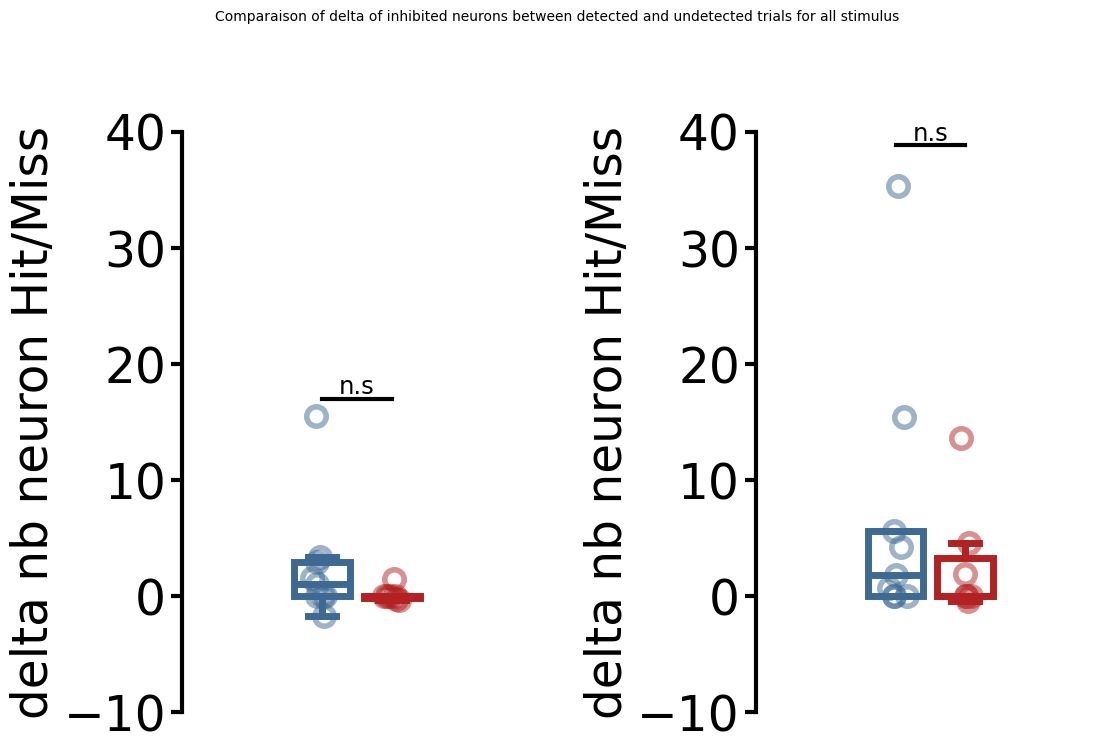

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.9161855308520199, pvalue=0.3615958379609641)
ShapiroResult(statistic=0.5992613672215592, pvalue=0.0002668321529332122)
MannwhitneyuResult(statistic=46.5, pvalue=0.11504062663497347)
4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7738945268151203, pvalue=0.010243670482615628)
ShapiroResult(statistic=0.9200772490497743, pvalue=0.4699926068825842)
MannwhitneyuResult(statistic=43.0, pvalue=0.23187712746828482)


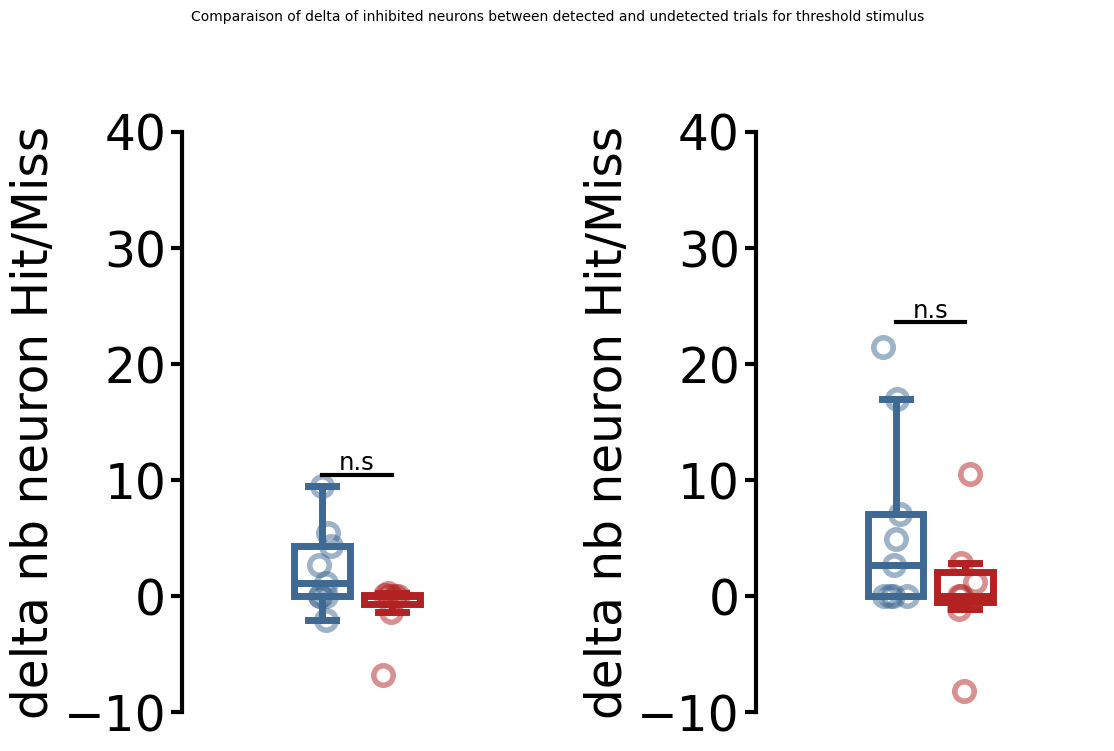

In [26]:
resp_contrast(pattern="inhibited", stim_ampl="all", method="delta", ylim=[-10, 40])
resp_contrast(pattern="inhibited", stim_ampl="threshold", method="delta", ylim=[-10, 40])

# Responsivity per amplitude line graphs 22/03/2024

## Graph of activated neurons from amplitude

In [27]:
def plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=True, undetected_trials=True, ylim=[], signif=False, sign_exc_inh=[[], []]):
    pat_dict = {"recruited": 0, "activated": 1, "inhibited": -1}
    assert detected_trials or undetected_trials
    genotype_dict = {"WT": 0, "KO": 1, "KO-Hypo": 2}
    anova_arr = np.empty((0, 4))
    fig, axs = plt.subplots(2, 1, figsize=(12, 16))
    labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
    amps = np.arange(2, 14, 2)
    
    for i, n_type in enumerate(["EXC","INH"]):
        wt, ko, ko_hypo = [], [], []
        for rec in recs.values():
            resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
            resp_p = []
            # The no-go trials are used to normalized
            trials_no_go = resp_mat[:, rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)]
            # The total number of neurons is computed
            total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
            
            trials_no_go[trials_no_go != 1] = 0
            recruited_no_go = np.mean(np.count_nonzero(trials_no_go,axis=0))
            # For each amplitude, the number of activated neurons is computed
            for amp in amps:
                if detected_trials and undetected_trials:
                    stim_filter = rec.stim_ampl == amp
                elif detected_trials:
                    stim_filter = np.logical_and(rec.detected_stim, rec.stim_ampl == amp)
                elif undetected_trials:
                    stim_filter = np.logical_and(np.invert(rec.detected_stim), rec.stim_ampl == amp)
                    
                trials = resp_mat[:, stim_filter]
                if pattern != "recruited":
                    trials[trials != pat_dict[pattern]] = 0
                recruited_det = np.mean(np.count_nonzero(trials, axis=0))
                # recruited_det -= recruited_no_go
                # recruited_det = 0 if recruited_det < 0 else recruited_det
                
                perc_n_det = (recruited_det/total_n)*100
                anova_arr = np.row_stack((anova_arr, np.array([genotype_dict[rec.genotype], perc_n_det, amp, rec.filename])))
                anova_df = pd.DataFrame(anova_arr, columns=["Genotype", "Neurons", "Amplitude", "ID"], dtype=float)
                if np.isfinite(perc_n_det):
                    resp_p.append(perc_n_det)
                else: 
                    resp_p.append(0)
                    
            if rec.genotype == "WT":
                wt.append(resp_p)
            elif rec.genotype =="KO-Hypo":
                ko_hypo.append(resp_p)
            elif rec.genotype =="KO":
                ko.append(resp_p)
        
        axs[i].errorbar(amps,np.nanmean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].errorbar(amps,np.nanmean(ko,axis=0),linestyle="-.", color="#c57c9a",yerr=ss.sem(ko,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].errorbar(amps,np.nanmean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(ko_hypo,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].grid(False)
        axs[i].set_facecolor("white")
        axs[i].spines["left"].set_color("black")
        axs[i].spines["bottom"].set_color("black")
        axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True, bottom=True)
        axs[i].set_ylabel("Neurons (%)")
        axs[i].set_xlabel("Stimulus amplitude")
        axs[i].set_xlim([0, 14])
        if ylim:
            axs[i].set_ylim(ylim)
        axs[i].set_title(labels[n_type])
        axs[i].tick_params(axis='both')
        axs[i].set_xticks(amps)
        axs[i].spines[['right', 'top',]].set_visible(False)
        axs[0].get_xaxis().set_visible(False)
        
        if signif:
            # print(ss.shapiro(wt, axis=1).pvalue)
            # print(ss.shapiro(ko).pvalue)
            # print(ss.shapiro(ko_hypo).pvalue)
            print(f"===== ANOVA Results for {labels[n_type]} =====")
            print("!! Please provide manually the significance levels to plot from table reading !!")
            aov = pg.mixed_anova(dv="Neurons", within="Amplitude", between="Genotype", subject="ID", data=anova_df)
            pg.print_table(aov)
            posthocs = pg.pairwise_tests(dv="Neurons", within="Amplitude", between="Genotype", subject="ID", data=anova_df)
            pg.print_table(posthocs)
            
            # for genotype in genotype_dict.keys():
            #     print(f"______________RM ANOVA ({genotype})______________")
            #     aov_wt = pg.rm_anova(dv="Neurons", within="Amplitude", subject="ID", data=anova_df.loc[anova_df['Genotype'] == genotype_dict[genotype]])
            #     pg.print_table(aov_wt)
            #     posthocs_wt = pg.pairwise_tests(dv="Neurons", within="Amplitude", subject="ID", data=anova_df.loc[anova_df['Genotype'] == genotype_dict[genotype]])
            #     pg.print_table(posthocs_wt)
            
            model_formula = "Neurons ~ ID + Genotype + Amplitude + Genotype:Amplitude"
            model = ols(model_formula, data=anova_df).fit()
            print(model.summary())  # View ANOVA table
            residuals = model.resid
            statistic, pvalue = ss.shapiro(residuals)
            print(f"\n Normality of the residuals -> pvalue: {pvalue} \n")
        
        if sign_exc_inh != [[], []]:
            for (x, y, sign) in zip(amps, np.max(np.array([np.nanmean(wt, axis=0), np.nanmean(ko, axis=0), np.nanmean(ko_hypo, axis=0)]), axis=0), sign_exc_inh[i]):
                if sign != "n.s":
                    axs[i].annotate(sign, xy=(x, y * 1.25), horizontalalignment="center", verticalalignment="center")
    trials_name = "all" if (detected_trials and undetected_trials) else "detected" if detected_trials else "undetected" if undetected_trials else "none"
    fig.suptitle(f"Percentage of activated neurons for {trials_name} trials", fontsize=10)
    plt.tight_layout()
    if save_figure:
        title = f"Figure2/responsivity/ampcurv_{pattern}_{trials_name}.pdf"
        fig.savefig(server_address + title)

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2       MS       F    p-unc    np2      eps
-----------  -------  -----  -----  -------  ------  -------  -----  -------
Genotype     630.047      2     15  315.023   4.042    0.039  0.350  nan
Amplitude    571.921      5     75  114.384  14.031    0.000  0.483    0.625
Interaction  146.206     10     75   14.621   1.793    0.076  0.193  nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True          -1.089  17.000  two-sided        0.291    0.407    -0.325
Amplitude             -             2.000   6.000  True     

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


                            OLS Regression Results                            
Dep. Variable:                Neurons   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     13.37
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           8.20e-09
Time:                        15:43:18   Log-Likelihood:                -312.43
No. Observations:                 108   AIC:                             634.9
Df Residuals:                     103   BIC:                             648.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.1533      3

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)



POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc      BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -------------  -------  --------  --------
Amplitude             -             2.000   4.000  True      True          -1.012  17.000  two-sided        0.326     0.380    -0.280
Amplitude             -             2.000   6.000  True      True          -1.788  17.000  two-sided        0.092     0.908    -0.462
Amplitude             -             2.000   8.000  True      True          -3.996  17.000  two-sided        0.001    39.592    -0.820
Amplitude             -             2.000  10.000  True      True          -6.373  17.000  two-sided        0.000  3076.237    -1.174
Amplitude             -             2.000  12.000  True      True          -4.266  17.000  two-sided        0.001    65.835    -0.997
Amplitude             -             4.000   6

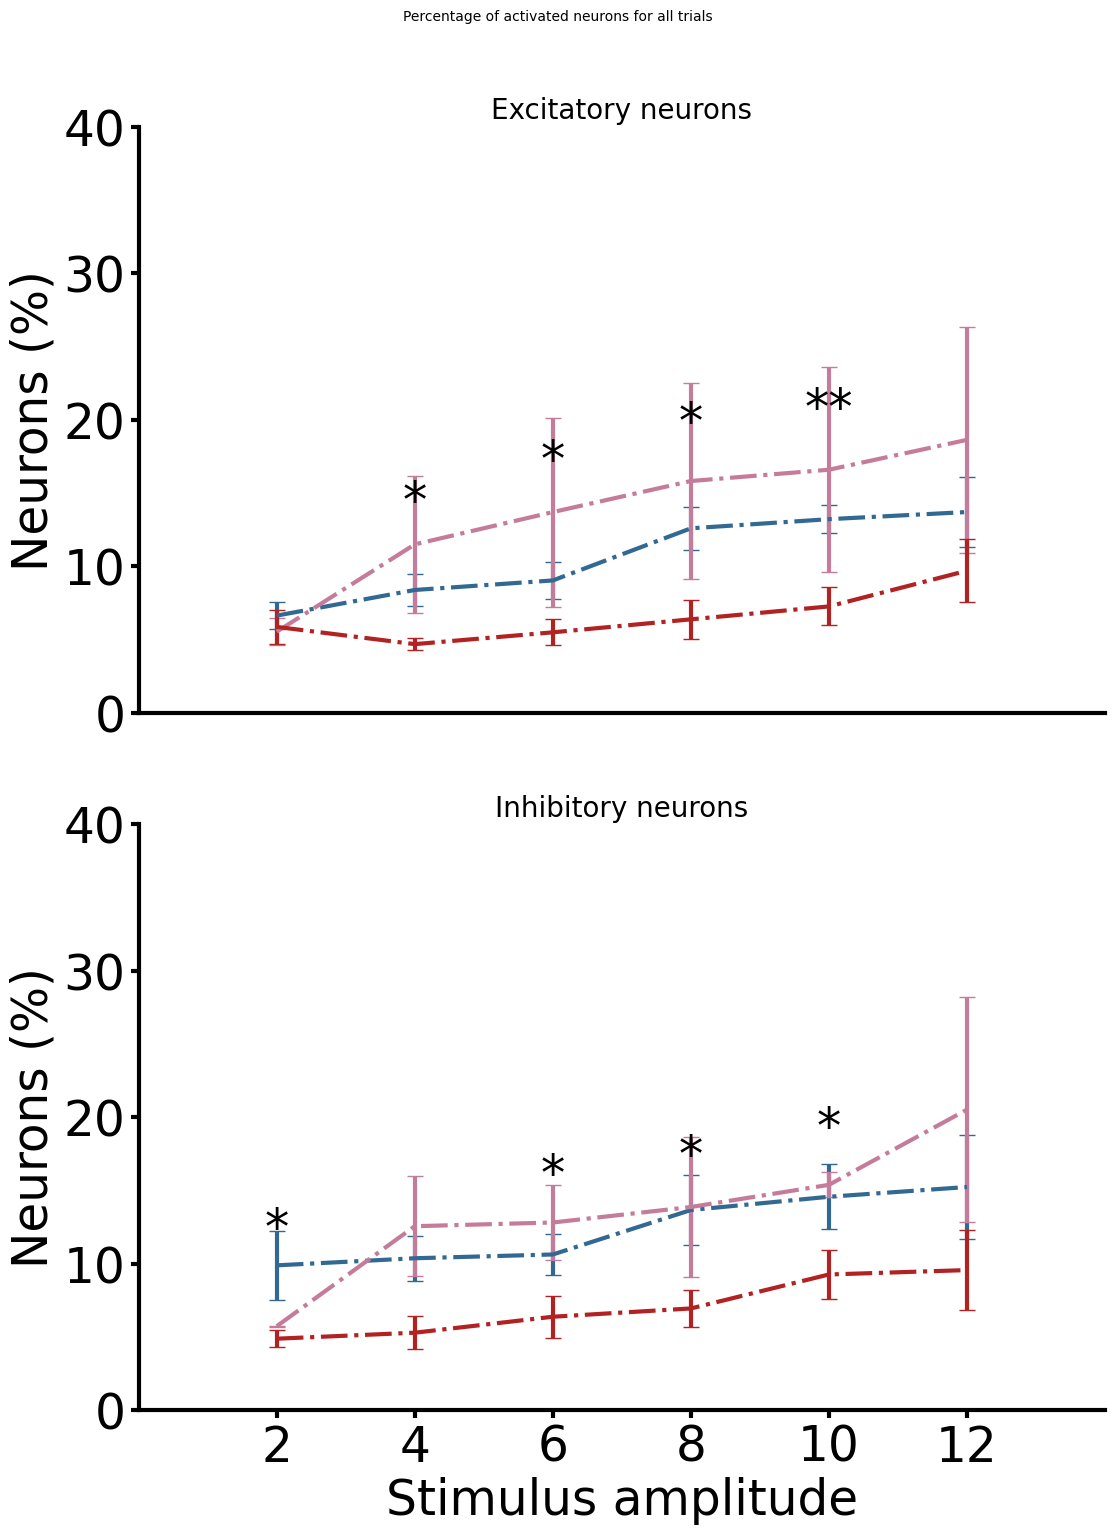

In [28]:
plot_neuron_perc_amp(recs, pattern="activated", detected_trials=True, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "*", "*", "*", "**", "n.s"], ["*", "n.s", "*", "*", "*", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2       MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  -------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     323.670      2      6  161.835  1.342    0.330      nan      0.309  nan           nan        nan        nan
Amplitude    219.719      5     30   43.944  2.452    0.056        0.160  0.290    0.420         0.000      0.010      0.020
Interaction  326.760     10     30   32.676  1.824    0.099      nan      0.378  nan           nan        nan        nan



C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= 


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            1.299  8.000  two-sided        0.230    0.619     0.682
Amplitude             -             2.000   6.000  True      True            0.999  8.000  two-sided        0.347    0.481     0.531
Amplitude             -             2.000   8.000  True      True            0.206  8.000  two-sided        0.842    0.328     0.090
Amplitude             -             2.000  10.000  True      True           -0.001  8.000  two-sided        0.999    0.322    -0.001
Amplitude             -             2.000  12.000  True      True           -0.384  8.000  two-sided        0.711    0.342    -0.162
Amplitude             -             4.000   6.000  T

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= 

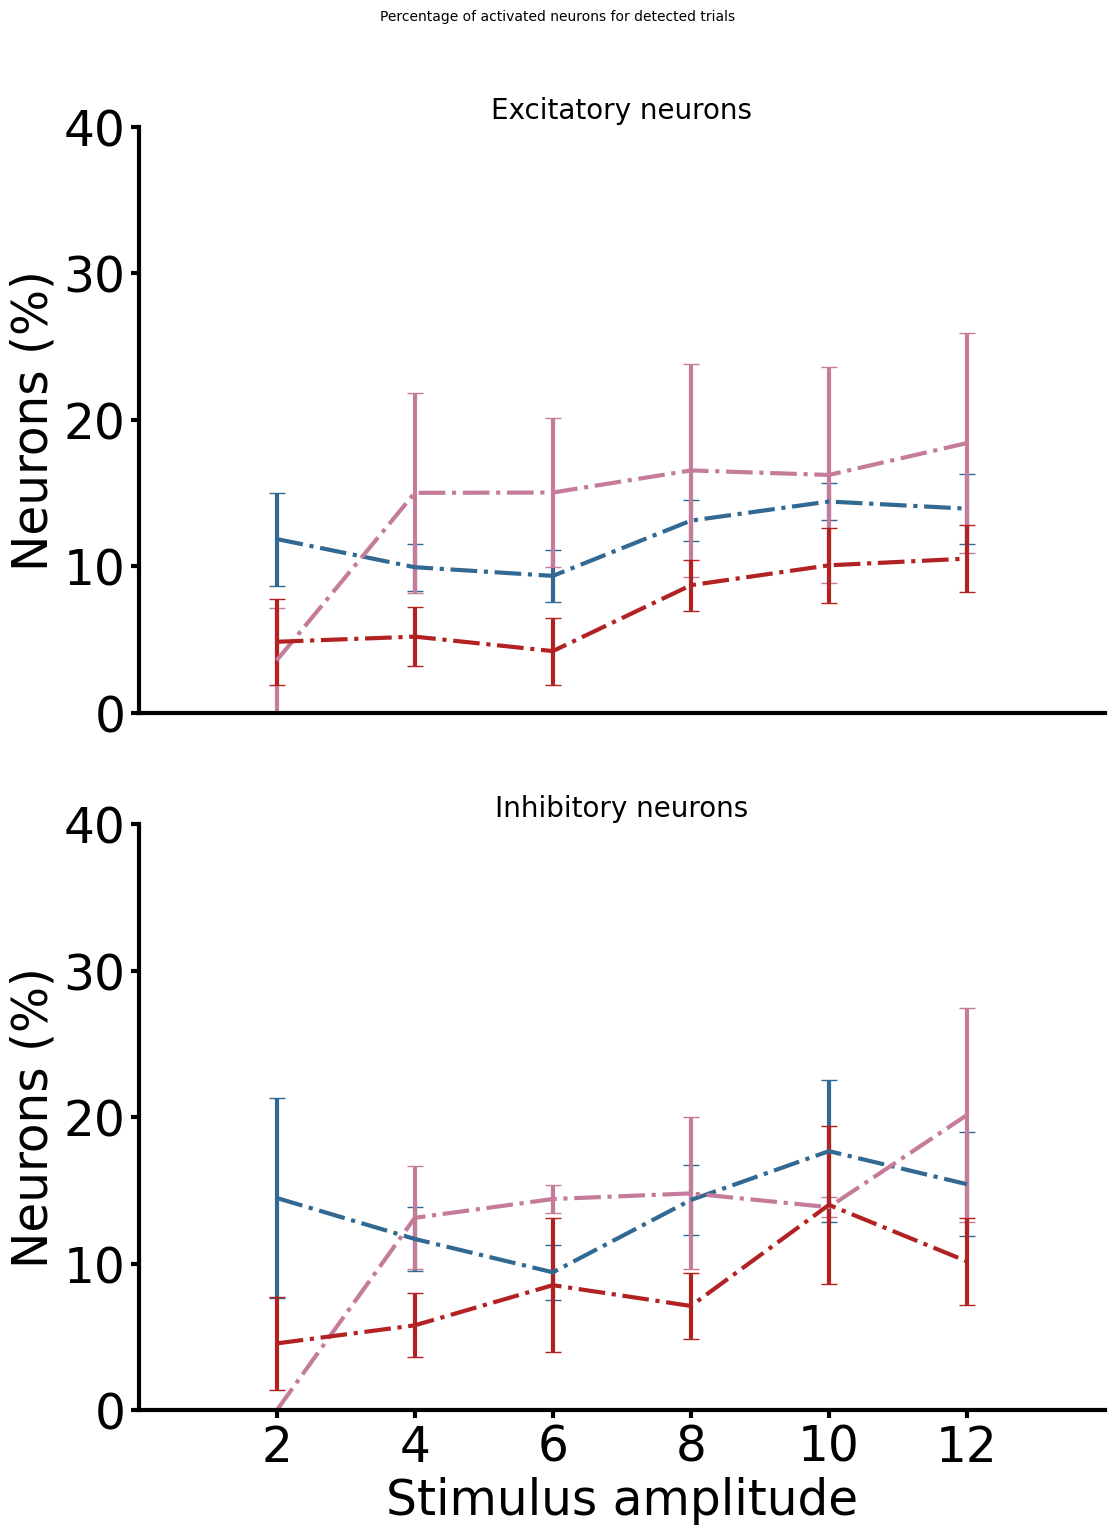

In [29]:
plot_neuron_perc_amp(recs, pattern="activated", detected_trials=True, undetected_trials=False, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     15.456      1      5  15.456  1.014    0.360      nan      0.169  nan           nan        nan        nan
Amplitude    53.150      5     25  10.630  4.499    0.005        0.087  0.474    0.469         0.000      0.001      0.030
Interaction  54.079      5     25  10.816  4.578    0.004      nan      0.478  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -----

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep


ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  ------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype       0.715      1      5   0.715  0.019    0.897      nan      0.004  nan           nan        nan        nan
Amplitude    100.823      5     25  20.165  2.691    0.044        0.099  0.350    0.363         0.000      0.000      0.005
Interaction   18.646      5     25   3.729  0.498    0.775      nan      0.091  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True           -0.739  6.00

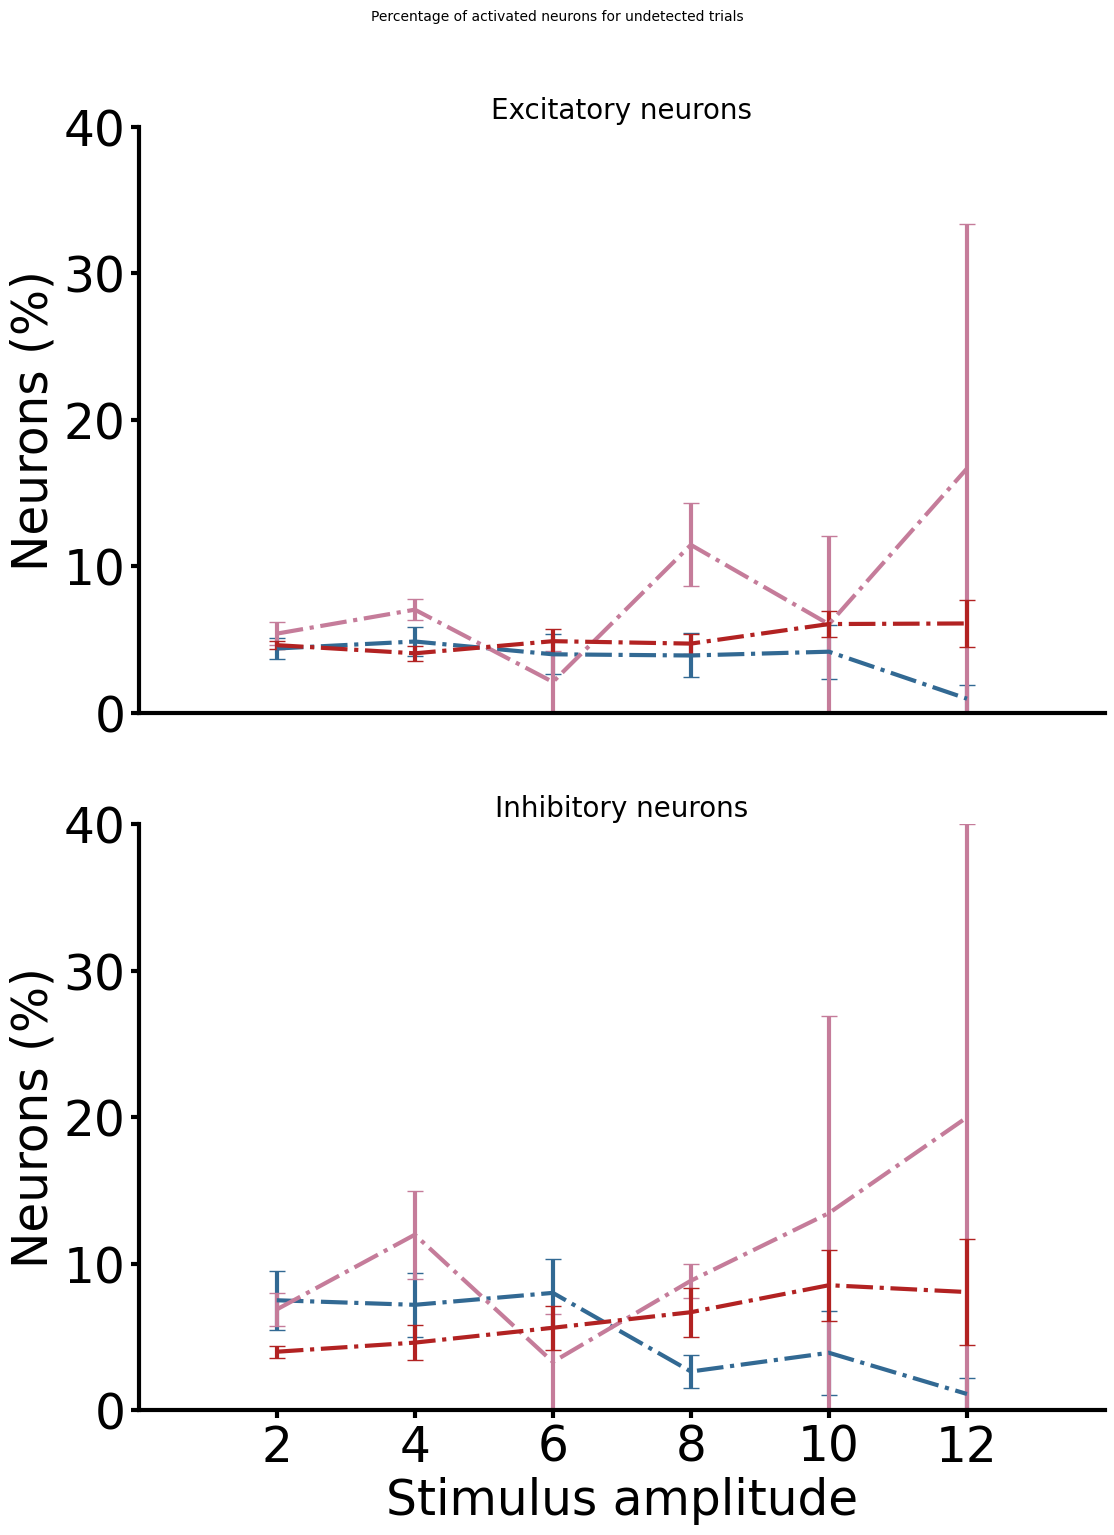

In [30]:
plot_neuron_perc_amp(recs, pattern="activated", detected_trials=False, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

## Graph of recruited neurons per amplitude

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source             SS    DF1    DF2       MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  --------  -----  -----  -------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     1316.345      2     15  658.173   4.479    0.030      nan      0.374  nan           nan        nan        nan
Amplitude     839.735      5     75  167.947  12.327    0.000        0.000  0.451    0.565         0.000      0.113      0.003
Interaction   240.134     10     75   24.013   1.762    0.083      nan      0.190  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc    BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  --

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


===== ANOVA Results for Inhibitory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source             SS    DF1    DF2        MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  --------  -----  -----  --------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     2127.615      2     15  1063.807   3.533    0.055      nan      0.320  nan           nan        nan        nan
Amplitude    1166.288      5     75   233.258  11.337    0.000        0.000  0.430    0.573         0.000      0.101      0.002
Interaction   290.126     10     75    29.013   1.410    0.192      nan      0.158  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ----------

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


                            OLS Regression Results                            
Dep. Variable:                Neurons   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     35.01
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           2.06e-22
Time:                        15:43:21   Log-Likelihood:                -762.26
No. Observations:                 216   AIC:                             1535.
Df Residuals:                     211   BIC:                             1551.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             42.7107      4

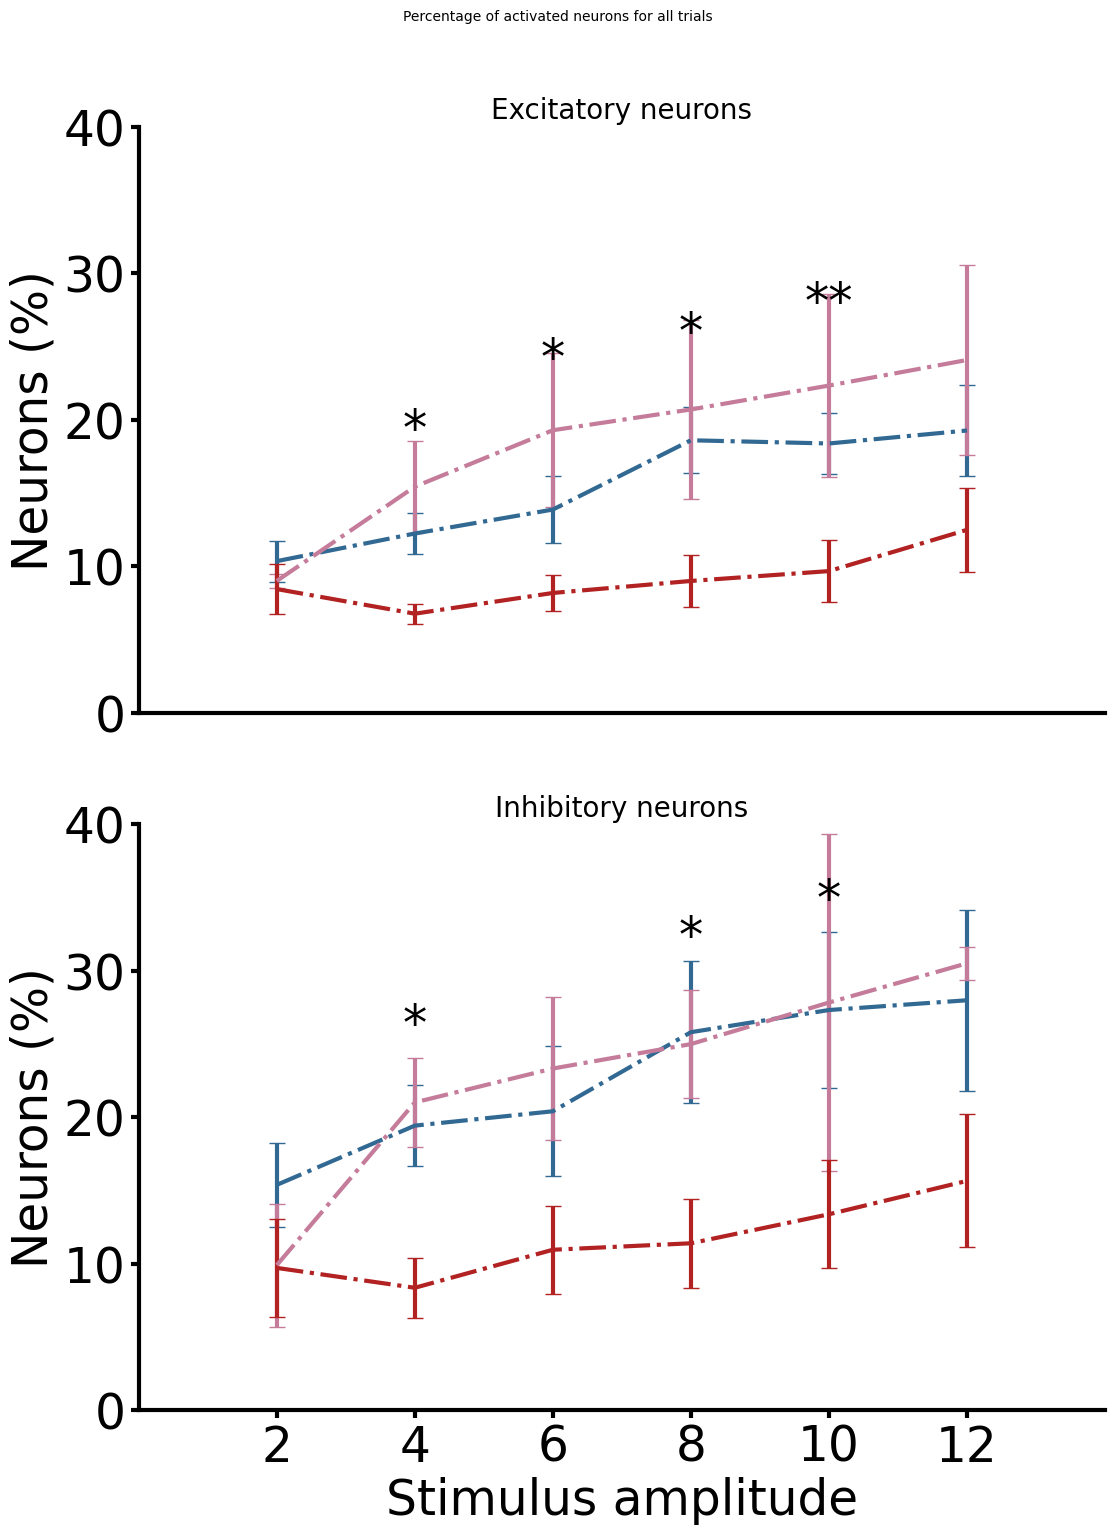

In [31]:
plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=True, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "*", "*", "*", "**", "n.s"], 
                                                                                                                                       ["n.s", "*", "n.s", "*", "*", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2       MS      F    p-unc    np2      eps
-----------  -------  -----  -----  -------  -----  -------  -----  -------
Genotype     294.249      2      6  147.125  0.942    0.441  0.239  nan
Amplitude    287.660      5     30   57.532  3.500    0.013  0.368    0.442
Interaction  432.624     10     30   43.262  2.632    0.020  0.467  nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            1.449  8.000  two-sided        0.185    0.713     0.756
Amplitude             -             2.000   6.000  True      True

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= 

                            OLS Regression Results                            
Dep. Variable:                Neurons   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     8.416
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           8.17e-06
Time:                        15:43:22   Log-Likelihood:                -315.33
No. Observations:                  95   AIC:                             640.7
Df Residuals:                      90   BIC:                             653.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             36.8383      6

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= 


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            1.052  8.000  two-sided        0.323    0.501     0.514
Amplitude             -             2.000   6.000  True      True            0.516  8.000  two-sided        0.620    0.360     0.202
Amplitude             -             2.000   8.000  True      True            0.255  8.000  two-sided        0.805    0.331     0.075
Amplitude             -             2.000  10.000  True      True           -0.241  8.000  two-sided        0.816    0.330    -0.053
Amplitude             -             2.000  12.000  True      True           -0.493  8.000  two-sided        0.635    0.356    -0.138
Amplitude             -             4.000   6.000  T

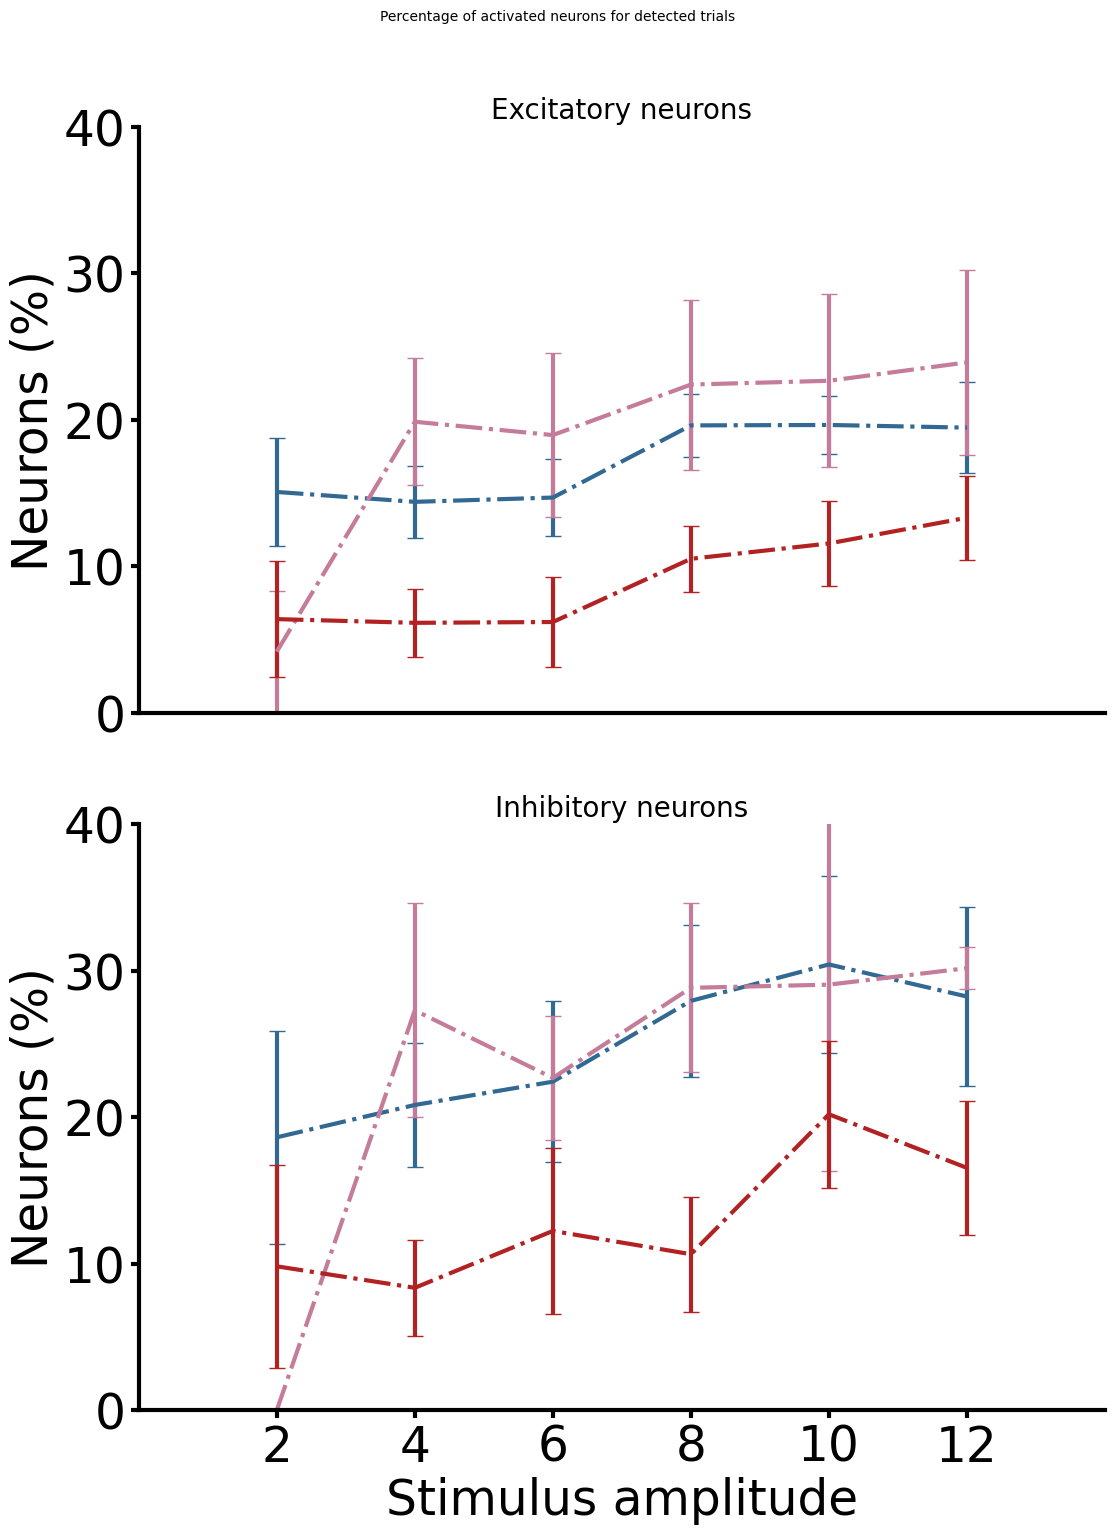

In [32]:
plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=True, undetected_trials=False, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     16.679      1      5  16.679  0.315    0.599      nan      0.059  nan           nan        nan        nan
Amplitude    78.848      5     25  15.770  1.759    0.158        0.211  0.260    0.296         0.000      0.000      0.001
Interaction  30.357      5     25   6.071  0.677    0.645      nan      0.119  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -----

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Inhibitory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  ------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype       7.801      1      5   7.801  0.054    0.826      nan      0.011  nan           nan        nan        nan
Amplitude    136.072      5     25  27.214  1.279    0.304        0.276  0.204    0.269         0.000      0.000      0.005
Interaction   31.724      5     25   6.345  0.298    0.909      nan      0.056  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  

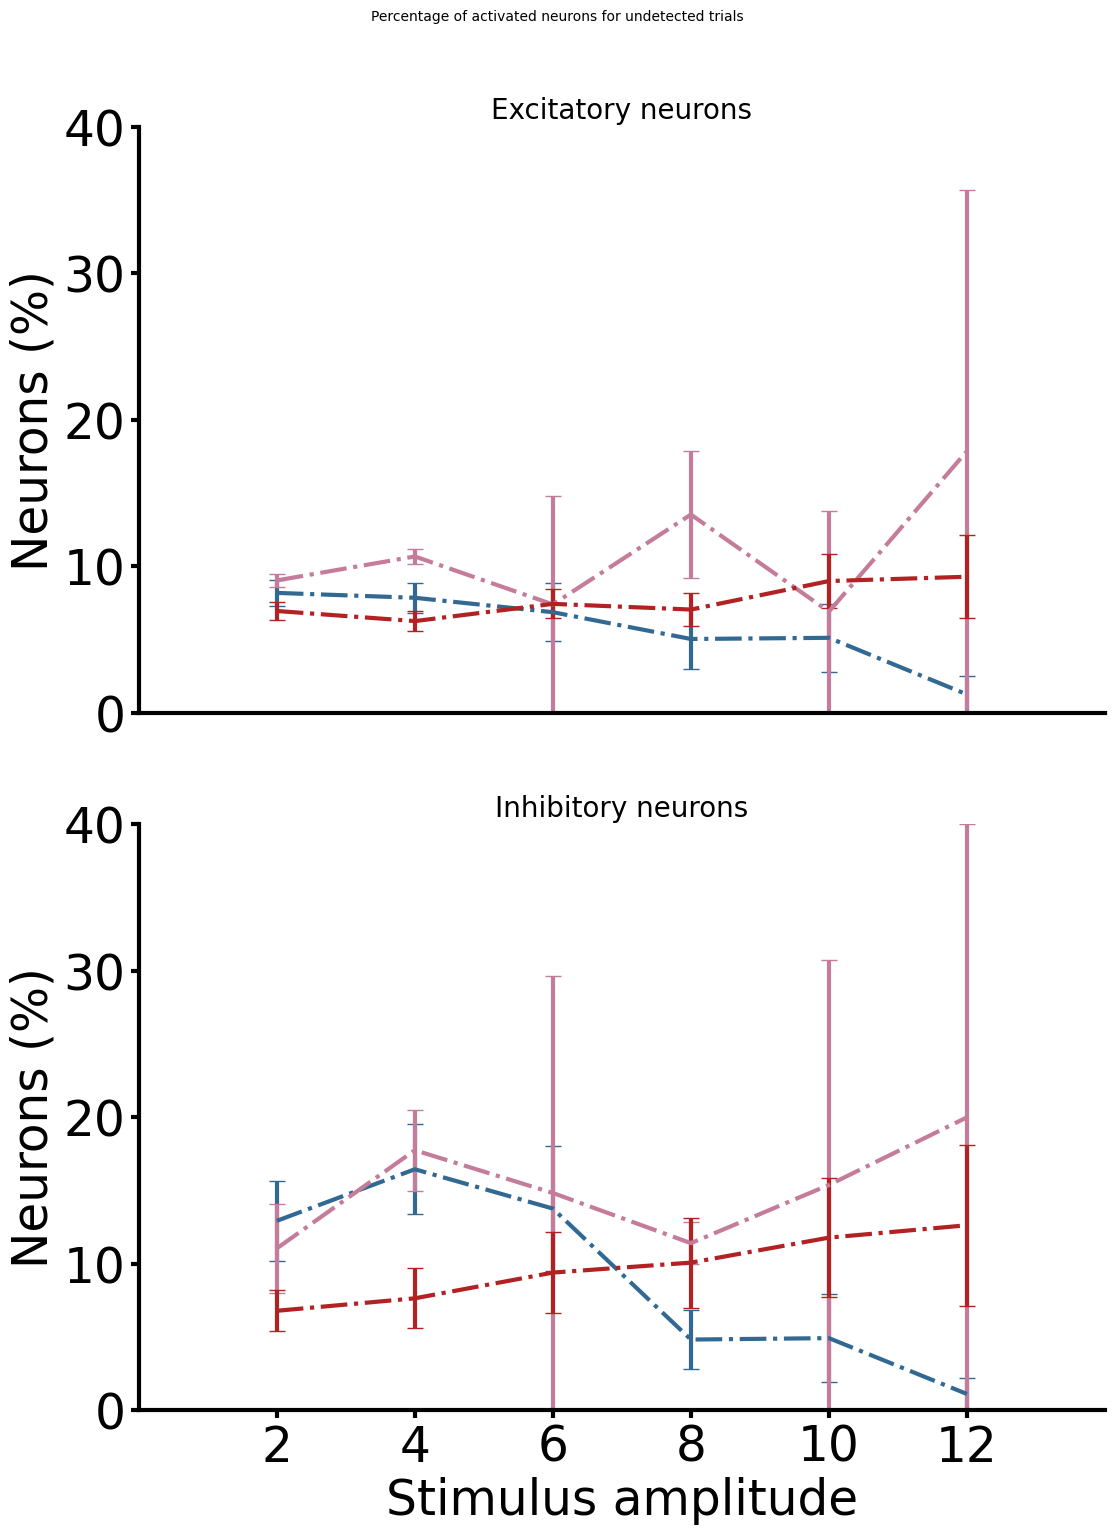

In [33]:
plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=False, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

## Graph of inhibited neurons per amplitude

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  ------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype     139.159      2     15  69.580  1.458    0.264      nan      0.163  nan           nan        nan        nan
Amplitude     32.657      5     75   6.531  1.328    0.262        0.252  0.081    0.321         0.000      0.006      0.000
Interaction   16.631     10     75   1.663  0.338    0.968      nan      0.043  nan           nan        nan        nan



C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc    BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -------------  -------  ------  --------
Amplitude             -             2.000   4.000  True      True           0.184  17.000  two-sided        0.856   0.247     0.041
Amplitude             -             2.000   6.000  True      True          -1.047  17.000  two-sided        0.310   0.392    -0.316
Amplitude             -             2.000   8.000  True      True          -1.310  17.000  two-sided        0.208   0.507    -0.414
Amplitude             -             2.000  10.000  True      True          -0.866  17.000  two-sided        0.399   0.338    -0.272
Amplitude             -             2.000  12.000  True      True          -1.080  17.000  two-sided        0.295   0.404    -0.344
Amplitude             -             4.000   6.000  True    

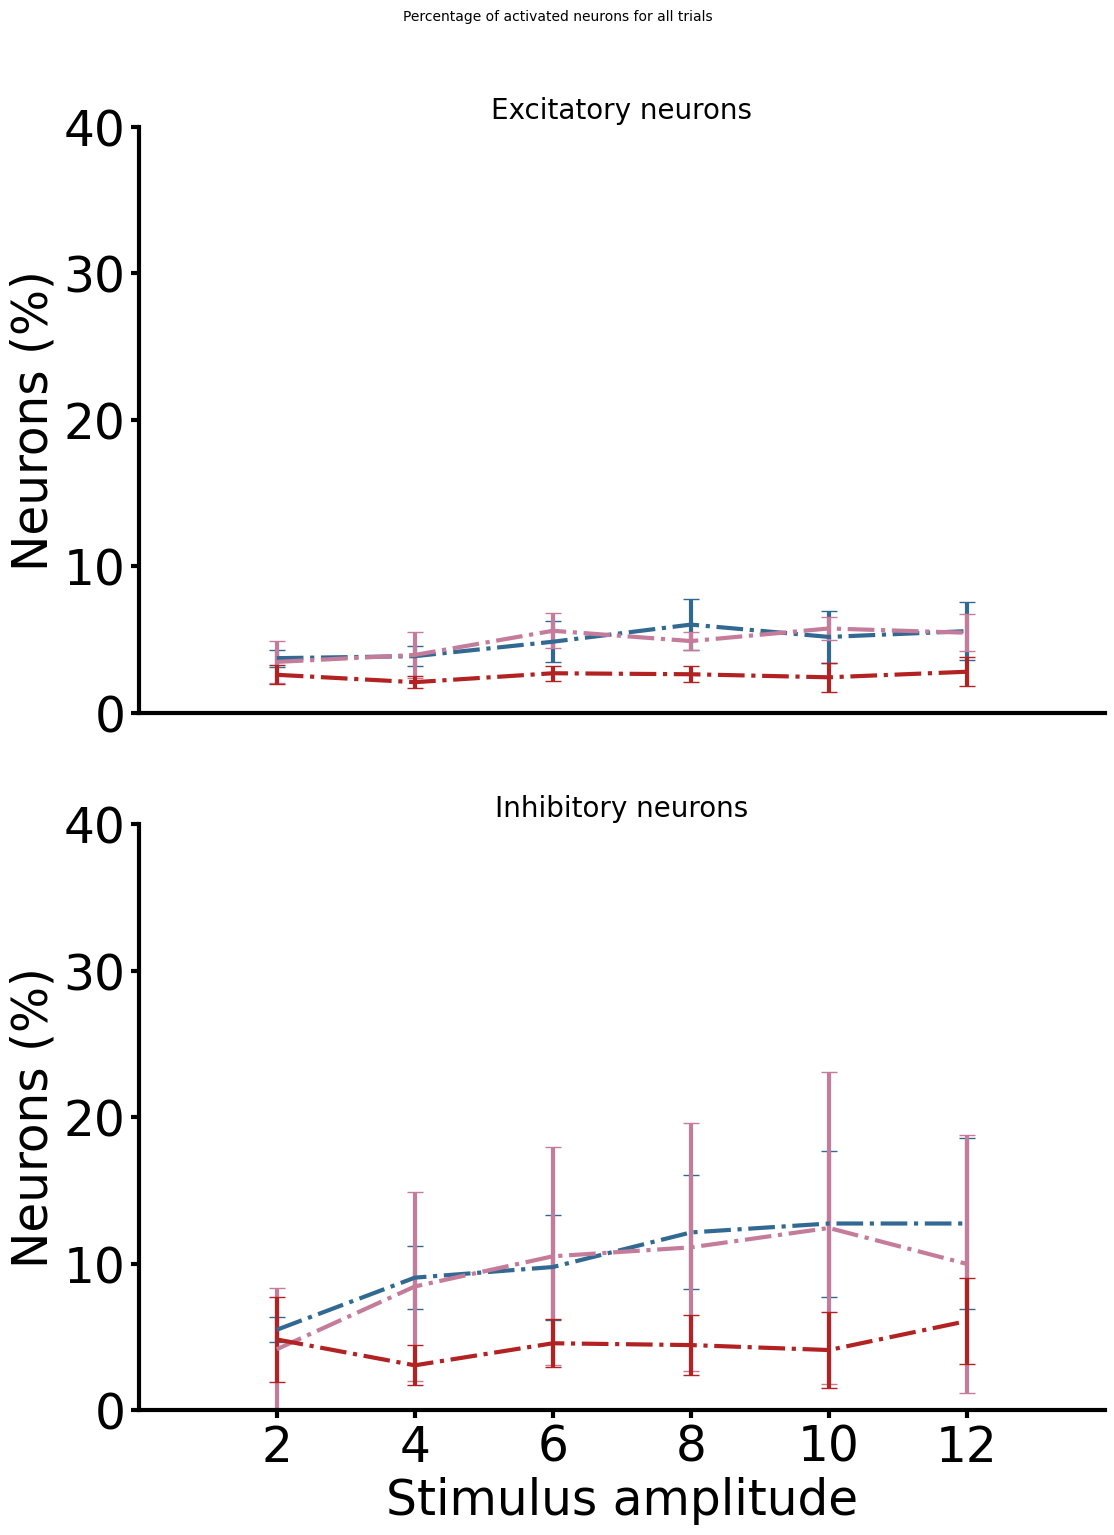

In [34]:
plot_neuron_perc_amp(recs, pattern="inhibited", detected_trials=True, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source           SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  ------  -----  -----  -----  -----  -------  -----  -------
Genotype      0.718      2      6  0.359  0.035    0.965  0.012  nan
Amplitude    11.484      5     30  2.297  0.783    0.570  0.115    0.524
Interaction  21.342     10     30  2.134  0.728    0.693  0.195  nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True            1.315  8.000  two-sided        0.225    0.628     0.534
Amplitude             -             2.000   6.000  True      True            0.2

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= 

                            OLS Regression Results                            
Dep. Variable:                Neurons   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     9.213
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           2.76e-06
Time:                        15:43:25   Log-Likelihood:                -247.84
No. Observations:                  95   AIC:                             505.7
Df Residuals:                      90   BIC:                             518.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             16.5040      3

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((

                            OLS Regression Results                            
Dep. Variable:                Neurons   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     8.083
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           4.99e-06
Time:                        15:43:25   Log-Likelihood:                -673.77
No. Observations:                 190   AIC:                             1358.
Df Residuals:                     185   BIC:                             1374.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.3762      5

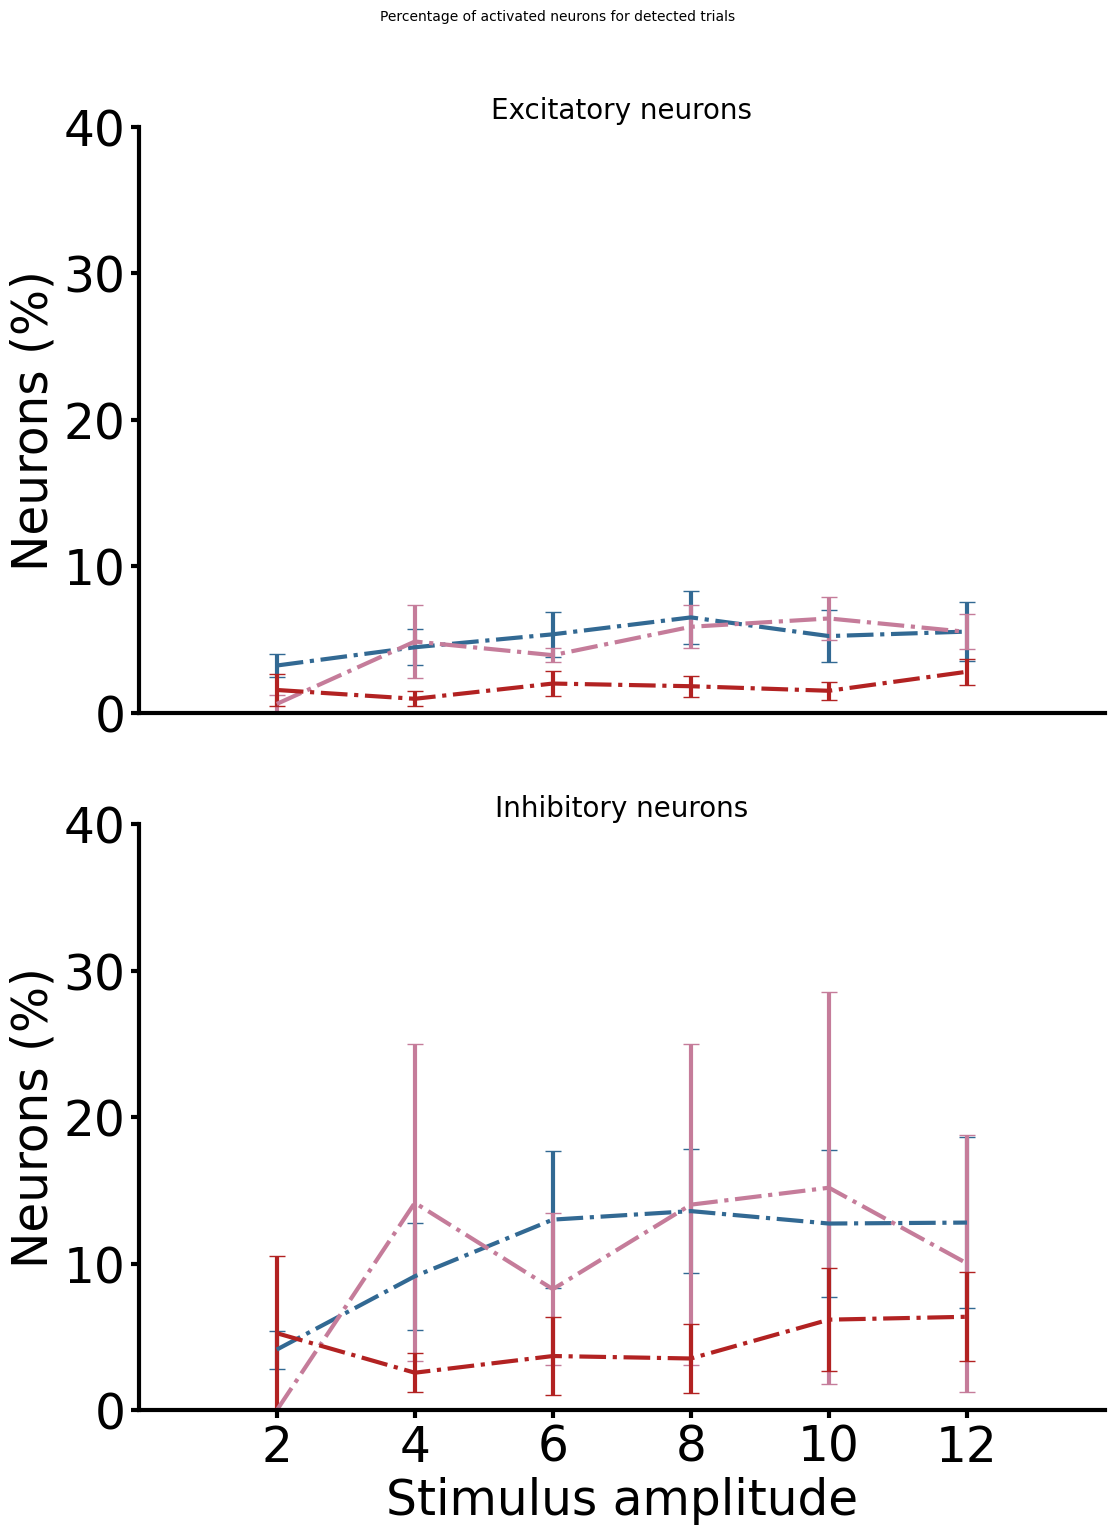

In [35]:
plot_neuron_perc_amp(recs, pattern="inhibited", detected_trials=True, undetected_trials=False, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source           SS    DF1    DF2     MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  -----  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype      0.023      1      5  0.023  0.001    0.974      nan      0.000  nan           nan        nan        nan
Amplitude     4.679      5     25  0.936  0.174    0.970        0.744  0.034    0.258         0.000      0.000      0.000
Interaction  20.925      5     25  4.185  0.777    0.576      nan      0.134  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  ----------

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percep

===== ANOVA Results for Inhibitory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source           SS    DF1    DF2     MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  -----  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Genotype      3.792      1      5  3.792  0.100    0.765      nan      0.020  nan           nan        nan        nan
Amplitude     6.485      5     25  1.297  0.151    0.978        0.783  0.029    0.289         0.000      0.000      0.000
Interaction  20.408      5     25  4.082  0.474    0.792      nan      0.087  nan           nan        nan        nan


POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric          T    dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  -------  -----  ----------

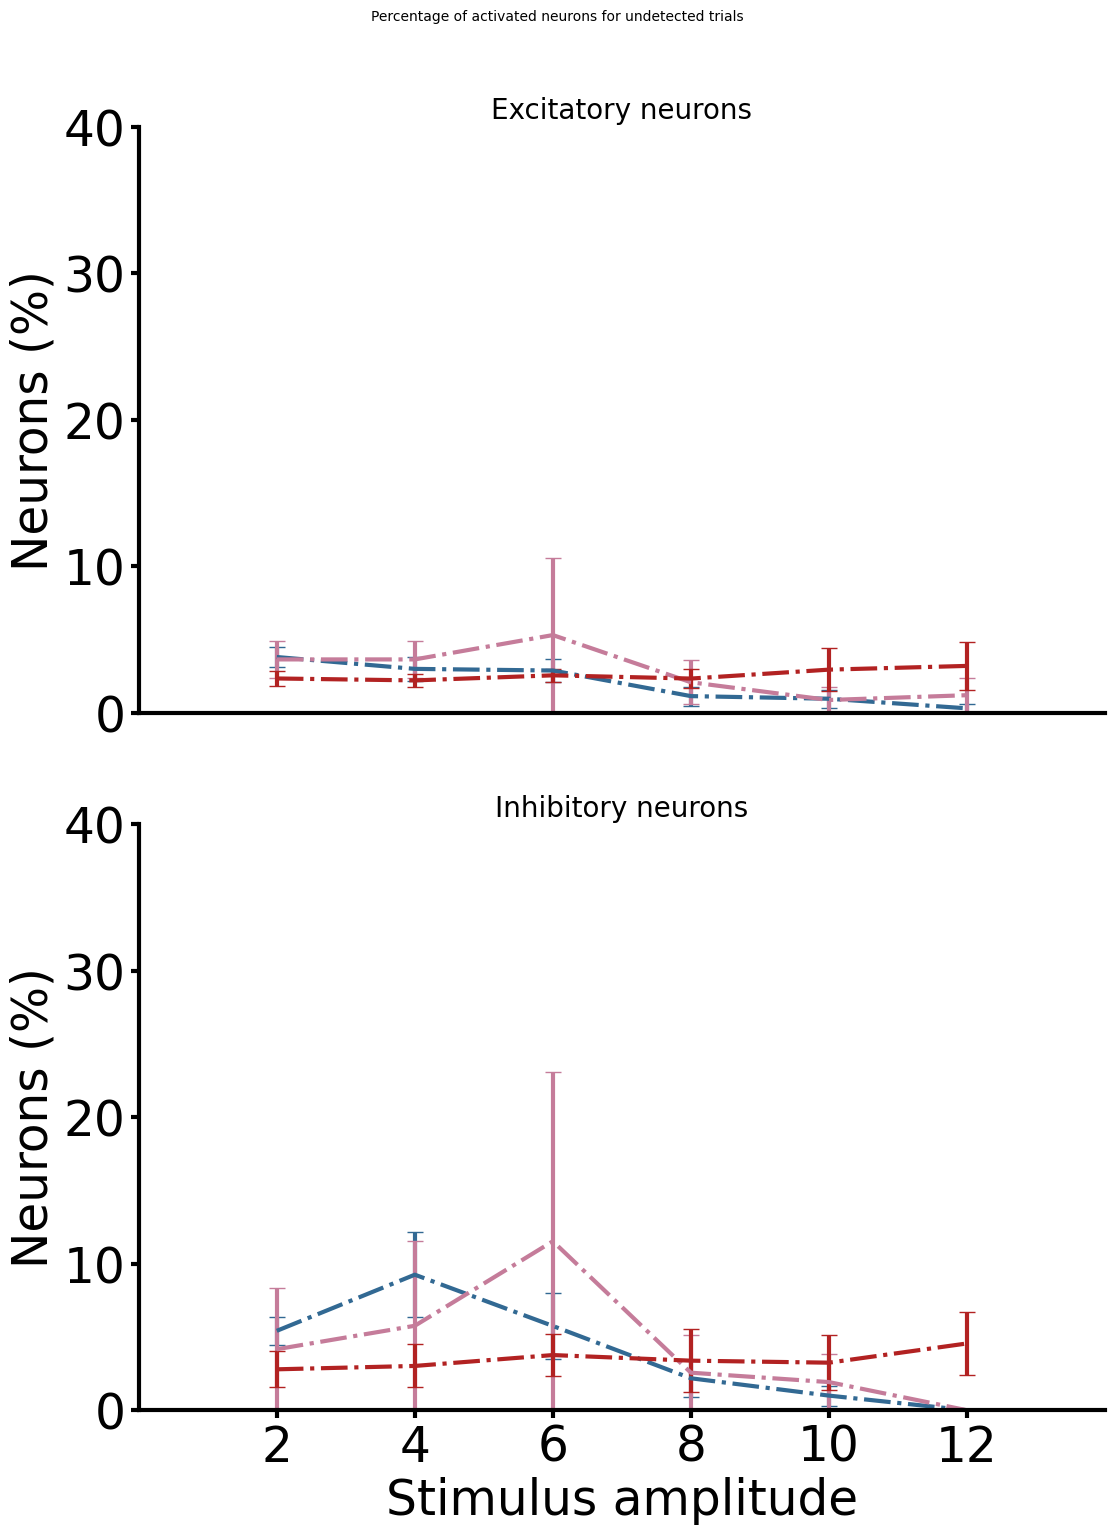

In [36]:
plot_neuron_perc_amp(recs, pattern="inhibited", detected_trials=False, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

## Graph of amplitude response from each stimulus amplitude


C:\Users\cvandromme\AppData\Local\Temp\ipykernel_6932\1602121083.py:15: RuntimeWarning: Mean of empty slice
  output = np.nanmean(np.nanmean(trials, axis=1))


NameError: name 'fig' is not defined

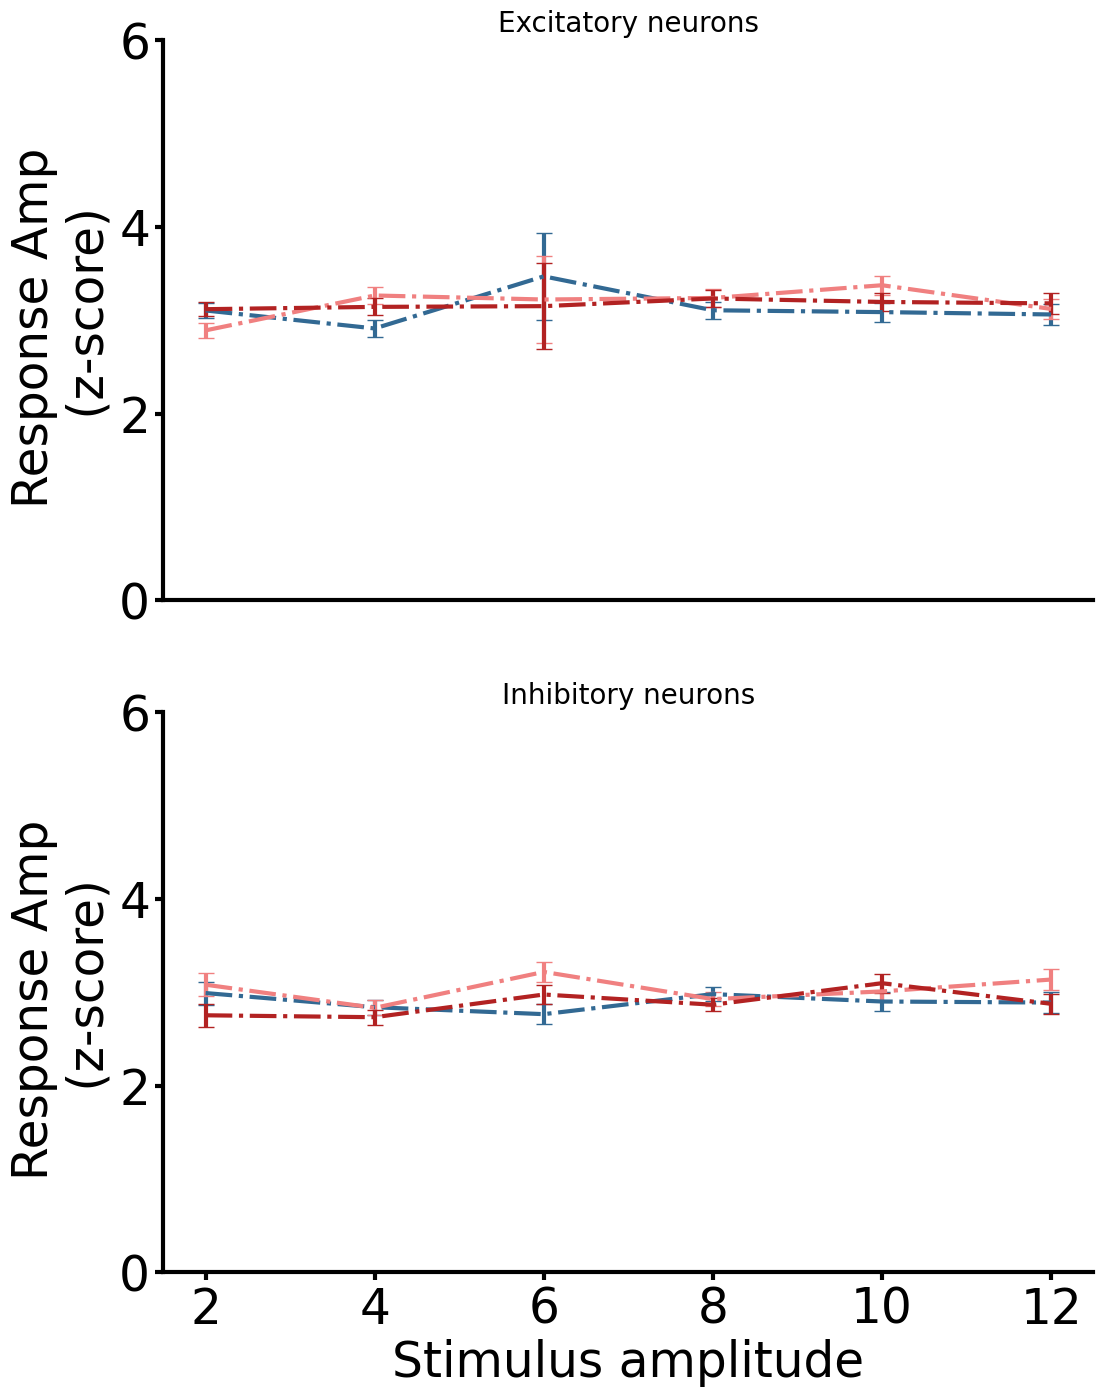

In [37]:
figs, axs = plt.subplots(2,1,figsize=(12,16))

amps=[2,4,6,8,10,12]
labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        rec.peak_delay_amp()
        mat = np.array(rec.matrices[type]["Peak_amplitude"])
        mat[mat<0]=np.nan

        _p=[]
        for amp in amps:
            trials = mat[:,rec.stim_ampl==amp]
            output = np.nanmean(np.nanmean(trials, axis=1))
            if np.isnan(output ):
                output = 0
            _p.append( output)
            
        if rec.genotype == "WT":
            wt.append(_p)

        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(_p)
        elif rec.genotype =="KO":
            ko.append(_p)
        
    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].grid(False)
    axs[i].set_facecolor("white")
    axs[i].spines["left"].set_color("black")
    axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True)
    axs[i].set_ylabel("Response Amp \n (z-score)")
    axs[i].set_xlabel("Stimulus amplitude")
    axs[i].set_title(labels[type])
    axs[i].tick_params(axis='both')
    axs[i].set_xticks([2,4,6,8,10,12])
    axs[i].set_ylim([0,6])
    axs[i].spines[['right', 'top',]].set_visible(False)
axs[0].get_xaxis().set_visible(False)
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/resp_amp_linegraph.pdf")

# Psychometric curves like graphs for fraction of resp neurons

Number of active neurons and behavior psychometric curves comparison animal by animals

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, rec_.stim_ampl == amp]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,35])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for all trials amplitude', fontsize=20)

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 1] = 0
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    nb_trials= []
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
        nb_trials.append(len(rec.stim_ampl[rec.stim_ampl == amp]))
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    # ax.bar([0, 2, 4, 6, 8, 10, 12], nb_trials)
    ax.set_title(title)
    ax.set_ylim([0,50])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for DETECTED TRIALS', fontsize=20)

percentage of neurons recruited for UNDETECTED TRIALS

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(~rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])

            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()

fig.suptitle('Percentage of neurons recruited for UNDETECTED TRIALS', fontsize=20)

# Signal-to-Noise ratio (nb of neurons due to stimulus vs nb of neurons bsl) 


In [ ]:
def SNR( pattern, n_type, ko, stim_ampl="all"):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_detected = resp_mat[:,ampl_det_filt]
        trials_undetected = resp_mat[:,ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0

        recruited_det = np.count_nonzero(trials_detected,axis=0)
        total_n = len(rec.zscore_exc)
        if  n_type== "INH":
            total_n = len(rec.zscore_inh)
        n_baseline = np.mean(np.count_nonzero(resp_mat[:,rec.stim_ampl==0],axis=0))
        # snr_det = (((np.mean(recruited_det)-n_baseline)/total_n)*100)  # option 1
        snr_det = np.mean(recruited_det)/n_baseline   # option 2
        #undetected
        recruited_undet = np.count_nonzero(trials_undetected,axis=0)
        # snr_undet =(((np.mean(recruited_undet)-n_baseline)/total_n)*100)  # option 1
        snr_undet = np.mean(recruited_undet)/n_baseline  # option 2

        if rec.genotype == "WT":
            wt_det.append(snr_det)
            wt_undet.append(snr_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
        elif rec.genotype == "KO" and ko =="KO":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
    return wt_det, ko_det, wt_undet, ko_undet

In [ ]:
    wt_det, ko_det, wt_undet, ko_undet = SNR(pattern=0, n_type="EXC", ko="KO-hypo", stim_ampl="all")
    fig, axs = plt.subplots(2, 2, figsize=(12,16))
    ylim= [0,70]
    ppt.boxplot(axs[0, 0], wt_det,ko_det,"SNR",ylim=ylim)
    axs[0, 0].set_title("SNR EXC Detected")
    ppt.boxplot(axs[0, 1], wt_undet,ko_undet,"SNR",ylim=ylim)
    axs[0, 1].set_title("SNR EXC Undetected")
    wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=0, n_type="INH", ko="ko-hypo", stim_ampl="all")
    ppt.boxplot(axs[1, 0], wt_det1,ko_det1,"SNR",ylim=ylim)
    axs[1, 0].set_title("SNR INH Detected")
    ppt.boxplot(axs[1, 1], wt_undet1,ko_undet1,"SNR",ylim=ylim)
    axs[1, 1].set_title("SNR INH Undetected")
    fig.tight_layout()
    fig.savefig(server_address + "Figure2/responsivity/SNR.pdf")

# Fraction of neurons active during no-Gos

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9461611273463697, pvalue=0.6480250556561007)
ShapiroResult(statistic=0.9397477723209465, pvalue=0.6364491522400489)
LeveneResult(statistic=0.0005458013077587891, pvalue=0.9816909286328154)
Equal variances :TtestResult(statistic=-0.43666331793407975, pvalue=0.6690148149630091, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9461611273463697, pvalue=0.6480250556561007)
ShapiroResult(statistic=0.9406397536807279, pvalue=0.6444890269294975)
LeveneResult(statistic=0.0002601743801232839, pvalue=0.9873583592245175)
Equal variances :TtestResult(statistic=-0.4410891007453026, pvalue=0.6658838811710999, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9348696162028438, pvalue=0.5290459899856355)
ShapiroResult(statistic=0.9236797014851812, pvalue=0.49851770642230686)
LeveneResult(statistic=0.05968348372214782, pvalue=0.810540948000751)
Equal variances :TtestResult(statistic=-0.48719542093

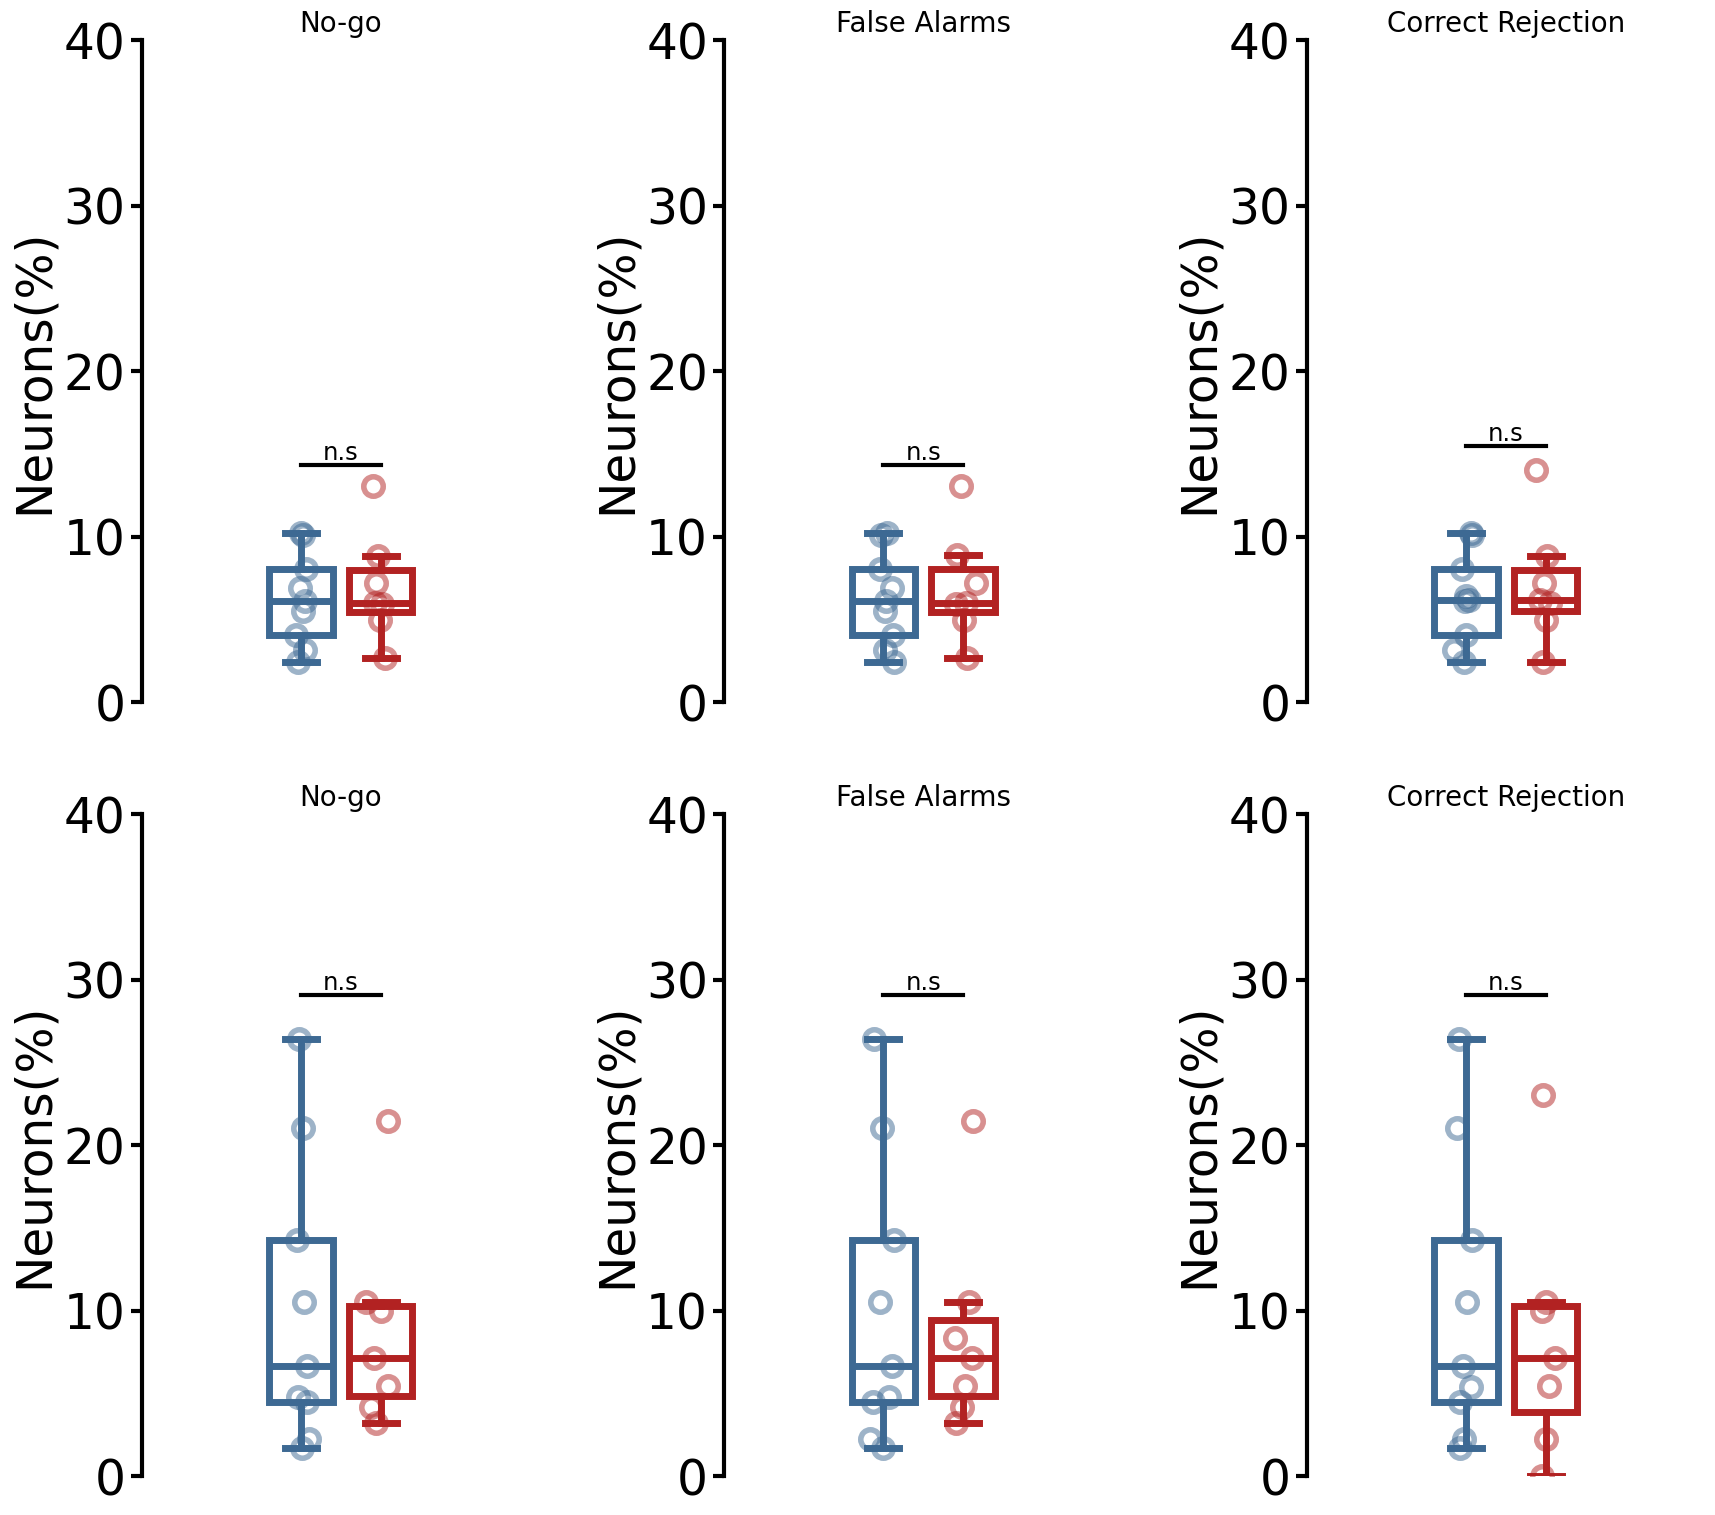

In [40]:
def nogo_fraction(n_type, ko, fa_cr_discrimination=True, return_fa=True):
    wt_det, ko_det = [], []
    
    for rec in recs.values():
        resp_mat = rec.matrices["EXC"]["Responsivity"]
        total_n = len(rec.zscore_exc)
        if n_type == "INH":
            resp_mat = rec.matrices["INH"]["Responsivity"]
            total_n = len(rec.zscore_inh)

        if fa_cr_discrimination:
            fa_timing, cr_timing = [], []
            no_go_timing = rec.stim_time[rec.stim_ampl==0]
            for i in no_go_timing:
                for y in rec.lick_time:
                    if y-i<30:
                        fa_timing.append(i)
                    else:    
                        cr_timing.append(i)
            n_baseline_fa = (np.mean(np.count_nonzero(resp_mat[:, np.isin(rec.stim_time, fa_timing)], axis=0)) / total_n) * 100          
            n_baseline_cr = (np.mean(np.count_nonzero(resp_mat[:, np.isin(rec.stim_time, cr_timing)], axis=0)) / total_n) * 100   
            
            if return_fa:
                n_baseline = n_baseline_fa
            else:
                n_baseline = n_baseline_cr
        else:
            n_baseline = (np.mean(np.count_nonzero(resp_mat[:, rec.stim_ampl == 0], axis=0)) / total_n) * 100
            
        if rec.genotype == "WT":
            wt_det.append(n_baseline)
        elif rec.genotype == "KO-Hypo":
            ko_det.append(n_baseline)

        elif rec.genotype == "KO" and ko == "KO":
            ko_det.append(n_baseline)

    return wt_det, ko_det

wt_exc_nogo, ko_exc_nogo = nogo_fraction(n_type="EXC", ko="KO-hypo", fa_cr_discrimination=False)
wt_exc_fa, ko_exc_fa = nogo_fraction(n_type="EXC", ko="ko-hypo", fa_cr_discrimination=True, return_fa=True)
wt_exc_cr, ko_exc_cr = nogo_fraction(n_type="EXC", ko="ko-hypo", fa_cr_discrimination=True, return_fa=False)
wt_inh_nogo, ko_inh_nogo = nogo_fraction(n_type="INH", ko="ko-hypo", fa_cr_discrimination=False)
wt_inh_fa, ko_inh_fa = nogo_fraction(n_type="INH",ko="ko-hypo", fa_cr_discrimination=True, return_fa=True)
wt_inh_cr, ko_inh_cr = nogo_fraction(n_type="INH", ko="ko-hypo", fa_cr_discrimination=True, return_fa=False)
fig, axs = plt.subplots(2, 3, figsize=(18, 16))
ylim = [0, 40]
ppt.boxplot(axs[0,0], wt_exc_nogo, ko_exc_nogo, paired=False, ylabel="Neurons(%)", ylim=ylim)
ppt.boxplot(axs[0,1], wt_exc_fa, ko_exc_fa, paired=False, ylabel="Neurons(%)", ylim=ylim)
ppt.boxplot(axs[0,2], wt_exc_cr, ko_exc_cr, paired=False, ylabel="Neurons(%)", ylim=ylim)
axs[0,0].set_title("No-go")
axs[0,1].set_title("False Alarms")
axs[0,2].set_title("Correct Rejection")
ppt.boxplot(axs[1,0], wt_inh_nogo, ko_inh_nogo, paired=False, ylabel="Neurons(%)", ylim=ylim)
ppt.boxplot(axs[1,1], wt_inh_fa, ko_inh_fa, paired=False, ylabel="Neurons(%)", ylim=ylim)
ppt.boxplot(axs[1,2], wt_inh_cr, ko_inh_cr, paired=False, ylabel="Neurons(%)", ylim=ylim)
axs[1,0].set_title("No-go")
axs[1,1].set_title("False Alarms")
axs[1,2].set_title("Correct Rejection")
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/nogo.pdf")

# Level of inhibition (nb of exc inhibited/ nb of inh activated) (No nogo normalization)

In [ ]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=-1, n_type="EXC", ko=False, stim_ampl="all",
                                                   no_go_normalize=False)
wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=1, n_type="INH", ko=False, stim_ampl="all",
                                                       no_go_normalize=False)
wt_nan = np.logical_and(wt_det1>0,wt_undet1>0)
ko_nan = np.logical_and(ko_det1>0,ko_undet1>0)
wt_det, ko_det, wt_undet, ko_undet = wt_det[wt_nan], ko_det[ko_nan], wt_undet[wt_nan], ko_undet[ko_nan]
wt_det1, ko_det1, wt_undet1, ko_undet1 = wt_det1[wt_nan], ko_det1[ko_nan], wt_undet1[wt_nan], ko_undet1[ko_nan]
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
ylim = [0, 2]
ppt.boxplot(axs[0], np.divide(wt_det, wt_det1), np.divide(ko_det, ko_det1), "Level of inhibition", ylim=ylim)
axs[0].set_title("Detected")
ppt.boxplot(axs[1], np.divide(wt_undet, wt_undet1), np.divide(ko_undet, ko_undet1), "Level of inhibition", ylim=ylim)
axs[1].set_title("Undetected")
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/inhbib_level.pdf")

# E/I ratio 

In [ ]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type="EXC", ko=False, stim_ampl="all", no_go_normalize=False)
wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=1, n_type="INH", ko=False, stim_ampl="all", no_go_normalize=False)

ylim =[0,4]
fig, axs = plt.subplots(1, 2, figsize=(12,8))
y0=np.round(np.divide(wt_det,wt_det1),3)
y1=np.round(np.divide(ko_det,ko_det1),3)
ppt.boxplot(axs[0],y0 ,y1,"E/I ratio",ylim=ylim)
axs[0].set_title("Detected")
y2=np.round(np.divide(wt_undet,wt_undet1),3)
y3=np.round(np.divide(ko_undet,ko_undet1),3)
ppt.boxplot(axs[1],y2[np.isfinite(y2)], y3[np.isfinite(y3)],"E/I ratio",ylim=ylim)
axs[1].set_title("Undetected")
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/EI_ratio.pdf")


# Nb and percentage of neurons in the fields of view

In [ ]:
def quantify_neur(n_type, ko="all"):
    wt_n, ko_n, wt_per, ko_per = [],[],[],[]
    for rec in recs.values():
        if n_type == "EXC":
            n_neur = rec.zscore_exc.shape[0]
            n_perc = (rec.zscore_exc.shape[0]/(rec.zscore_exc.shape[0]+rec.zscore_inh.shape[0]))*100

        elif n_type == "INH":
            n_neur = rec.zscore_inh.shape[0]
            n_perc = (rec.zscore_inh.shape[0]/(rec.zscore_inh.shape[0]+rec.zscore_exc.shape[0]))*100

        if rec.genotype == "WT":
            wt_n.append(n_neur)
            wt_per.append(n_perc)
        elif rec.genotype =="KO-Hypo":
            ko_n.append(n_neur)
            ko_per.append(n_perc)
        elif rec.genotype == "KO" and ko =="KO":
            ko_n.append(n_neur)
            ko_per.append(n_perc)

    return wt_n, ko_n, wt_per, ko_per

In [ ]:
quantify_neur("EXC")

In [ ]:
wt_exc, ko_exc, wt_per_e, ko_per_e = quantify_neur("EXC",ko="KO-hy")
wt_inh, ko_inh, wt_per_i, ko_per_i = quantify_neur("INH",ko="KO-hypo")
fig, axs = plt.subplots(2, 2, figsize=(12,16))
ppt.boxplot(axs[0,0],wt_exc ,ko_exc,"Nb Neurons exc",ylim=[0, 150])
ppt.boxplot(axs[0,1],wt_inh ,ko_inh,"Nb Neurons inh",ylim=[0, 150])
ppt.boxplot(axs[1,0],wt_per_e ,ko_per_e,"% Neurons exc",ylim=[0, 100])
ppt.boxplot(axs[1,1],wt_per_i ,ko_per_i,"% Neurons inh",ylim=[0, 100])
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/neurons_field_of_view.pdf")
